# **Dataset context**

The **IBM HR Analytics Employee Attrition & Performance** dataset provides a fictional snapshot of an organization's workforce aimed at helping HR teams and data analysts identify the factors that contribute to employee turnover and performance trends. It features both demographic and job-related variables, enabling the development of predictive models and strategic insights to improve employee retention.

# **Dataset content**
There are 1,470 observations and 35 variables, including:


*   **Age, Gender, MaritalStatus, Education, EducationField** — employee demographics

*   **Department, JobRole, BusinessTravel, OverTime** — job characteristics and work patterns

*   **DistanceFromHome, EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance, RelationshipSatisfaction** — job experience and well‑being

*   **MonthlyIncome, HourlyRate, PercentSalaryHike, StockOptionLevel** — compensation info

*   **TotalWorkingYears, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager, NumCompaniesWorked, TrainingTimesLastYear** — career progression & training metrics
*   **PerformanceRating, JobInvolvement** — performance indicators

*   **DailyRate, MonthlyRate, StandardHours, EmployeeCount, EmployeeNumber, Over18** — various administrative identifiers; some hold constant values and are often dropped during preprocessing

*   **Attrition** — the target variable: whether the employee left (“Yes”/“No”)

*(source: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)*


In [1]:
%%capture
!pip install streamlit

In [2]:
%%capture
!pip install catboost

In [3]:
%%capture
!pip install imblearn

In [4]:
%%capture
!pip install catboost
!pip install xgboost

In [5]:
%%capture
!pip install threadpoolctl -U

In [6]:
!pip install pandas==1.3.4 --quiet

In [7]:
# Standard library imports
import os
import pickle
import warnings
from typing import Dict, Any

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing and model selection
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Imbalanced-learn preprocessing
import imblearn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Classifiers
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
import xgboost
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
from sklearn.metrics._plot.precision_recall_curve import precision_recall_curve

# Model persistence
import joblib
from joblib import dump, load

# Suppress warnings
warnings.filterwarnings('ignore')

os.environ['OMP_NUM_THREADS']='1'

# **Functions**

In [8]:
def crosstab_categorical(df: pd.DataFrame) -> None:
    """Print crosstabs of 'Attrition' vs. each categorical column in df_cat_col."""
    for col in df_cat_col:
        print(pd.crosstab(df['Attrition'], df[col]))

In [9]:
def cap_upper_iqr(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    Caps only the upper outliers in specified columns using the IQR method.
    """
    df_capped = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR
        df_capped[col] = df[col].clip(upper=upper_bound)  # No lower bound applied
    return df_capped

In [10]:
def get_feature_importance_df(
    pipeline: SklearnPipeline,
    preprocessor: ColumnTransformer
) -> pd.DataFrame:
    """
    Extracts feature importances from a model pipeline.
    """
    model: BaseEstimator = pipeline.named_steps['model']
    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                transformed_names = transformer.get_feature_names_out(columns)
            else:
                transformed_names = columns
            feature_names.extend(transformed_names)

    importances = model.feature_importances_

    return pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

In [11]:
def compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred):
    """
    Calculate key classification metrics for train and test data.
    Returns a dictionary with confusion matrix, accuracy, precision,
    recall, F1 score, ROC AUC, and average precision.
    """
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    metrics = {
        'confusion_matrix': (tn, fp, fn, tp),
        'accuracy_train': accuracy_score(y_train, y_pred_tr),
        'accuracy_test': accuracy_score(y_test, y_pred),
        'precision_train': precision_score(y_train, y_pred_tr, average='binary'),
        'precision_test': precision_score(y_test, y_pred, average='binary'),
        'recall_train': recall_score(y_train, y_pred_tr),
        'recall_test': recall_score(y_test, y_pred),
        'f1_train': f1_score(y_train, y_pred_tr),
        'f1_test': f1_score(y_test, y_pred),
        'roc_auc_test': roc_auc_score(y_test, y_pred),
        'average_precision_test': average_precision_score(y_test, y_pred)
    }

    return metrics

In [12]:
def plot_roc_curve(model, X_test, y_test) -> None:
    """
    Display ROC curve for a trained classifier.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)
    plt.show()

In [13]:
def plot_precision_recall_curve(model, X_test, y_test) -> None:
    """
    Plot the Precision-Recall curve with average precision.
    """
    y_scores = model.predict_proba(X_test)[:, 1]
    prec, rec, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)

    plt.figure(figsize=(12, 7))
    plt.plot(rec, prec, label=f'Average precision-recall score: {avg_precision:.2f}')
    plt.title('Precision-Recall Curve', size=20)
    plt.xlabel('Recall', size=14)
    plt.ylabel('Precision', size=14)
    plt.legend()
    plt.show()

In [14]:
def create_model_summary_row(model_name: str, metrics: Dict[str, Any]) -> Dict[str, Any]:
    """
    Create a summary dictionary for classification model performance.
    """
    tn, fp, fn, tp = metrics['confusion_matrix']

    return {
        'model': model_name,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp + tn,
        'incorrect': fp + fn,
        'accuracy_train': metrics['accuracy_train'],
        'accuracy_test': metrics['accuracy_test'],
        'precision_train': metrics['precision_train'],
        'precision_test': metrics['precision_test'],
        'recall_train': metrics['recall_train'],
        'recall_test': metrics['recall_test'],
        'f1_train': metrics['f1_train'],
        'f1_test': metrics['f1_test'],
        'roc_auc': metrics['roc_auc_test'],
        'avg_pre': round(metrics['average_precision_test'], 3)
    }

# **Load the data**

In [15]:
#df = pd.read_csv("/content/drive/MyDrive/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df = pd.read_csv("./data/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# **EDA**

In [16]:
# Shape of data
df.shape

(1470, 35)

In [17]:
# First 5 rows of data
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [18]:
# Last 5 rows of data
df.tail()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8
1469,34,No,Travel_Rarely,628,Research & Development,8,3,Medical,1,2068,...,1,80,0,6,3,4,4,3,1,2


In [19]:
# Check duplicates - there are no duplicates
len(df[df.duplicated()])

0

In [20]:
# Columns names
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [21]:
# Data types - there are categorical and numerical columns
df.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [22]:
# Unique values in each column
pd.Series({c: df[c].unique() for c in df})

Age                         [41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35, 2...
Attrition                                                           [Yes, No]
BusinessTravel                 [Travel_Rarely, Travel_Frequently, Non-Travel]
DailyRate                   [1102, 279, 1373, 1392, 591, 1005, 1324, 1358,...
Department                   [Sales, Research & Development, Human Resources]
DistanceFromHome            [1, 8, 2, 3, 24, 23, 27, 16, 15, 26, 19, 21, 5...
Education                                                     [2, 1, 4, 3, 5]
EducationField              [Life Sciences, Other, Medical, Marketing, Tec...
EmployeeCount                                                             [1]
EmployeeNumber              [1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16,...
EnvironmentSatisfaction                                          [2, 3, 4, 1]
Gender                                                         [Female, Male]
HourlyRate                  [94, 61, 92, 56, 40, 79, 81, 67, 44,

In [23]:
# Number of unique values for each column - some columns have few unque values whereas others - almost for each row
df.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

In [24]:
# Check missing values - no missing values
sum(df.isna().sum())

0

In [25]:
# Data details
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [26]:
# Dataset is completely imbalanced - 1233 employees stayed at company vs 237 left
df['Attrition'].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

In [27]:
# The further distance from home, the less employees are in the company from this particular area
df['DistanceFromHome'].value_counts()

2     211
1     208
10     86
9      85
3      84
7      84
8      80
5      65
4      64
6      59
16     32
11     29
24     28
23     27
29     27
15     26
18     26
26     25
25     25
20     25
28     23
19     22
14     21
12     20
17     20
22     19
13     19
21     18
27     12
Name: DistanceFromHome, dtype: int64

In [28]:
# The most employees work at R&D Department, the least - in HR
df['Department'].value_counts()

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

In [29]:
# Drop columns  - no significant meaning for further analysis
# Column EmployeCount represents the amount of employees with particular EmployeeNumber - it is always 1
# Each employee is Over18
# Each emlpoyee works 80 hours - column StandardHours
df.drop(columns=['EmployeeCount', 'Over18', 'EmployeeNumber', 'StandardHours'], inplace=True)

In [30]:
# Change the type for columns to categorical
df['BusinessTravel'] = df['BusinessTravel'].astype('category')
df['Department'] = df['Department'].astype('category')
df['EducationField'] = df['EducationField'].astype('category')
df['JobRole'] = df['JobRole'].astype('category')
df['MaritalStatus'] = df['MaritalStatus'].astype('category')

In [31]:
# Change the type for columns to binary
df['Attrition'] = np.where(df['Attrition'] == 'Yes', 1, 0)
df['Gender'] = np.where(df['Gender'] == 'Female', 1, 0)
df['OverTime'] = np.where(df['OverTime'] == 'Yes', 1, 0)

In [32]:
# Check the details after change - less memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       1470 non-null   int64   
 1   Attrition                 1470 non-null   int32   
 2   BusinessTravel            1470 non-null   category
 3   DailyRate                 1470 non-null   int64   
 4   Department                1470 non-null   category
 5   DistanceFromHome          1470 non-null   int64   
 6   Education                 1470 non-null   int64   
 7   EducationField            1470 non-null   category
 8   EnvironmentSatisfaction   1470 non-null   int64   
 9   Gender                    1470 non-null   int32   
 10  HourlyRate                1470 non-null   int64   
 11  JobInvolvement            1470 non-null   int64   
 12  JobLevel                  1470 non-null   int64   
 13  JobRole                   1470 non-null   catego

In [33]:
# Statistics for categorical data
df.describe(include='category').T

,count,unique,top,freq
BusinessTravel,1470,3,Travel_Rarely,1043
Department,1470,3,Research & Development,961
EducationField,1470,6,Life Sciences,606
JobRole,1470,9,Sales Executive,326
MaritalStatus,1470,3,Married,673


In [34]:
# Statistics for numerical data - the highest valuesare highlighted in red
df_num_col = df.select_dtypes(exclude=['category']).columns
df_num = df[df_num_col]
df_num.describe().T.style.background_gradient(cmap='Oranges')

,count,mean,std,min,25%,50%,75%,max
Age,1470.000000,36.923810,9.135373,18.000000,30.000000,36.000000,43.000000,60.000000
Attrition,1470.000000,0.161224,0.367863,0.000000,0.000000,0.000000,0.000000,1.000000
DailyRate,1470.000000,802.485714,403.509100,102.000000,465.000000,802.000000,1157.000000,1499.000000
DistanceFromHome,1470.000000,9.192517,8.106864,1.000000,2.000000,7.000000,14.000000,29.000000
Education,1470.000000,2.912925,1.024165,1.000000,2.000000,3.000000,4.000000,5.000000
EnvironmentSatisfaction,1470.000000,2.721769,1.093082,1.000000,2.000000,3.000000,4.000000,4.000000
Gender,1470.000000,0.400000,0.490065,0.000000,0.000000,0.000000,1.000000,1.000000
HourlyRate,1470.000000,65.891156,20.329428,30.000000,48.000000,66.000000,83.750000,100.000000
JobInvolvement,1470.000000,2.729932,0.711561,1.000000,2.000000,3.000000,3.000000,4.000000
JobLevel,1470.000000,2.063946,1.106940,1.000000,1.000000,2.000000,3.000000,5.000000


In [35]:
# Present cross tabs for all categorical columns separately
df_cat_col = df.select_dtypes(include=['category']).columns
crosstab_categorical(df)

BusinessTravel  Non-Travel  Travel_Frequently  Travel_Rarely
Attrition                                                   
0                      138                208            887
1                       12                 69            156
Department  Human Resources  Research & Development  Sales
Attrition                                                 
0                        51                     828    354
1                        12                     133     92
EducationField  Human Resources  Life Sciences  Marketing  Medical  Other  \
Attrition                                                                   
0                            20            517        124      401     71   
1                             7             89         35       63     11   

EducationField  Technical Degree  
Attrition                         
0                            100  
1                             32  
JobRole    Healthcare Representative  Human Resources  Laboratory Techn

In [36]:
# The percentage of employees who left and stayed
df['Attrition'] = df['Attrition'].astype(int)
print('Stay:', round(df['Attrition'].value_counts()[0] / len(df) * 100, 2), '% of the dataset')
print('Left:', round(df['Attrition'].value_counts()[1] / len(df) * 100, 2), '% of the dataset')

Stay: 83.88 % of the dataset
Left: 16.12 % of the dataset


# **Visualization**

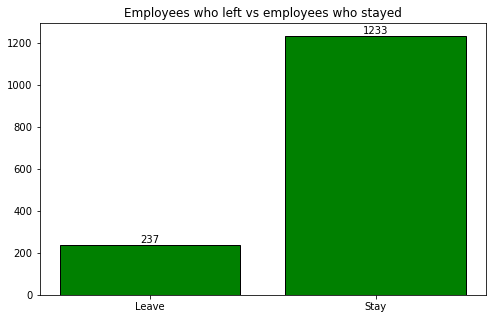

In [37]:
# Based on below bar chart for Attrition column, dataset is not well balanced (84% stay vs 16% leave)
left = (df[df['Attrition'] == 1]).count()
stay = (df[df['Attrition'] == 0]).count()
data = [left[0], stay[0]]
labels = ['Leave', 'Stay']
plt.figure(figsize=(8, 5))
plt.title('Employees who left vs employees who stayed')
bars = plt.bar(labels, data, color='green', edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, str(yval), ha='center', va='bottom')
plt.show()

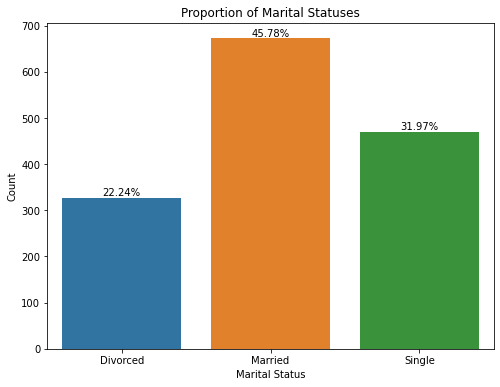

In [38]:
# The most people are married, the least - divorced
marital_status = df['MaritalStatus'].value_counts()

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='MaritalStatus')
plt.title('Proportion of Marital Statuses')
plt.xlabel('Marital Status')
plt.ylabel('Count')

total = len(df['MaritalStatus'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
plt.show()

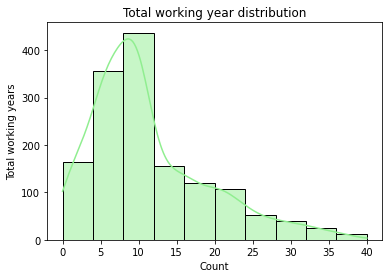

In [39]:
# Total working years distribution
sns.histplot(df['TotalWorkingYears'], kde=True, bins=10, color='lightgreen')
plt.title("Total working year distribution")
plt.xlabel('Count')
plt.ylabel('Total working years')
plt.show()

*   The distribution is not symmetric - it has long tail to the right - most employees have fewer years of experience, while a few have a lot.
*   The most common total working experience falls in the 8-10 year range - workforce consisted of mid-career professionals.
*   The count drop significantly after 15 years of experience - it is possible that fewer employees stay in the company long enough to reach higher salary.
*   Very experienced people are very rare in the company.

<AxesSubplot:>

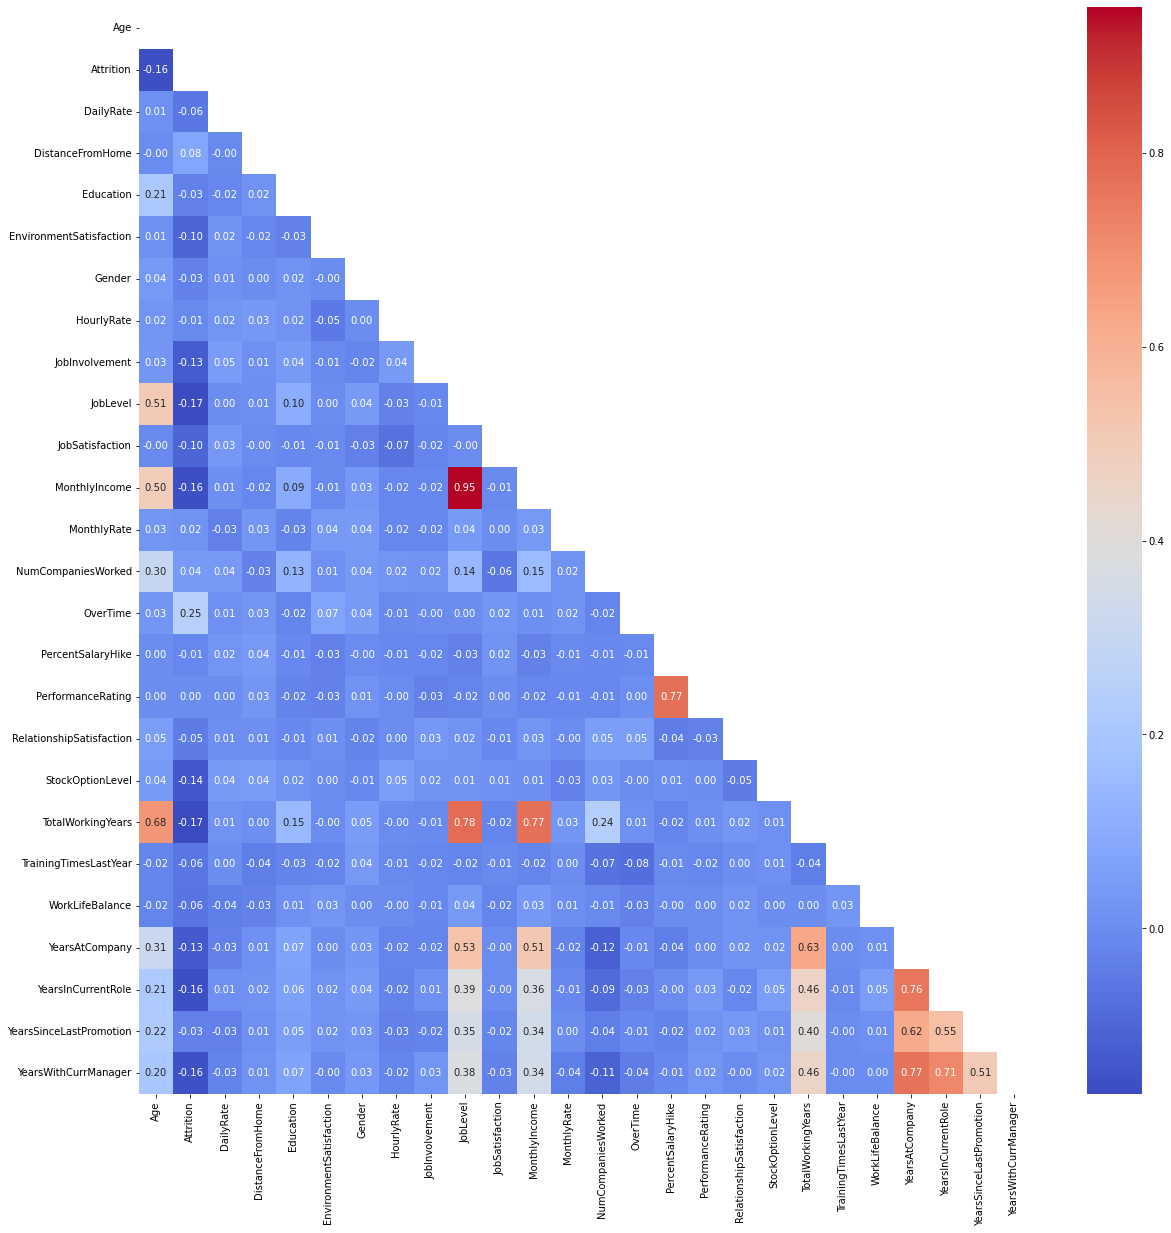

In [40]:
# Plot numeric correlation with heatmap
corr = df.select_dtypes(exclude=['category']).corr()
plt.figure(figsize=(20, 20))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, mask=mask, cmap = 'coolwarm', fmt = ".2f")

## **Remarks for correlation with Attrition column**

*   JobInvolvement has one of the moderate negative correlaction wit attrition level at -0.13.
*   Changes in attrition level can be explained by about 3% changes in JobLevel.
*   MonthlyIncome has negative correlation with attrition level at -0.16.
*   Changes in attrition level can be explained by about 6% changes in OverTime. This correlation is the biggest.
*   StockOptionLevel, TotalWorkingYears, YearsAtCompany, YearsInCurrentRole, YearsWithCurrManager have also negative correcaltion with attrition level at -0.14, -0.17, -0.13, -0.16 and -0.16 accordingly.

## **Remarks for other correlations**

*   There is strong correlation (above 0.7) between following columns: MonthlyIncome/JobLevel, TotalWorkingYears/JobLevel, TotalWorkingYears/MonthlyIncome, PerformanceRating/PercentSalaryHike, YearsInCurrentRole/YearsAtCompany, YearsWithCurrManager/YearAtCompany, YearsWithCurrManager/YearsInCurrentRole.
*   However, one correlation is extremly high - between MonthlyIncome and JobLevel. Due to this fact, MonthlyIncome column will be eliminated from further analysis to make the form filled quicker.
* Columns:
 - NumCompaniesWorked, abs correlation 0.04
 - Education, Gender, YearsSinceLastPromotion, abs correlation 0.03
 - MonthlyRate, abs correlation 0.02
 - HourlyRate, PercentSalaryHike, abs correlation 0.01
 - PerformanceRating, correlation 0.00

 are weakly correlated with attrition level. The model without them will be considered.





























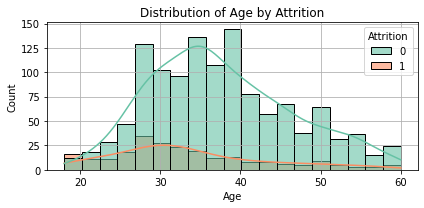

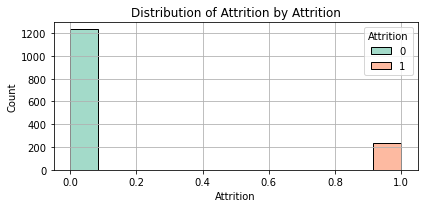

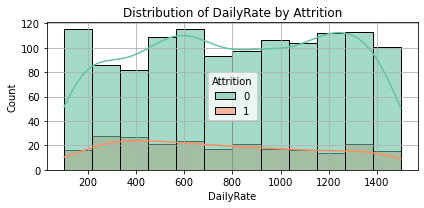

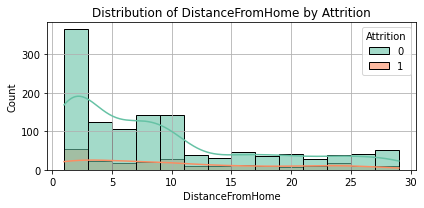

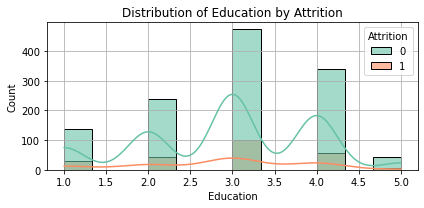

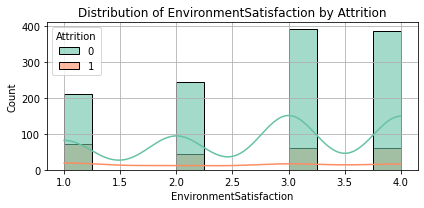

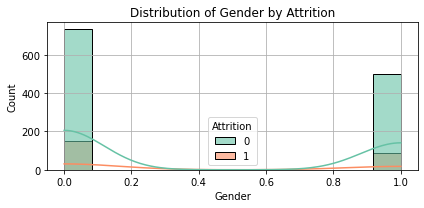

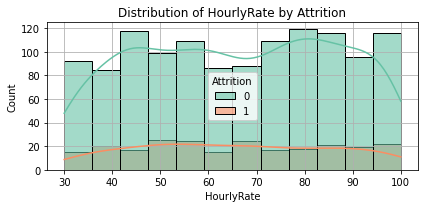

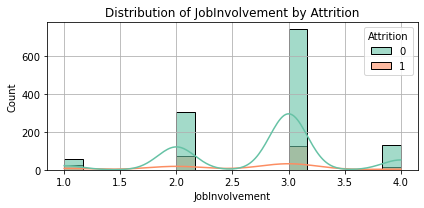

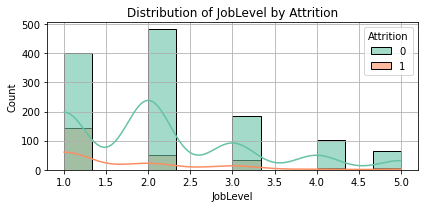

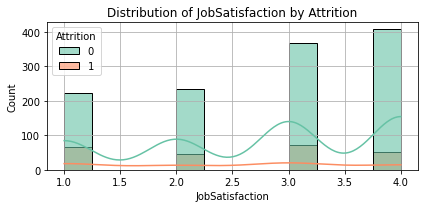

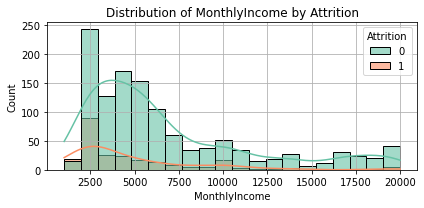

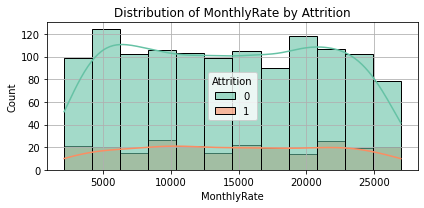

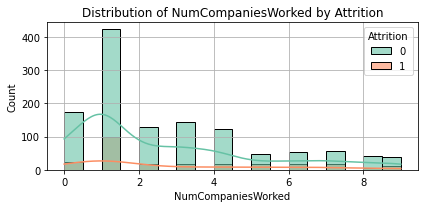

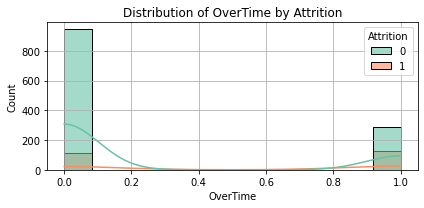

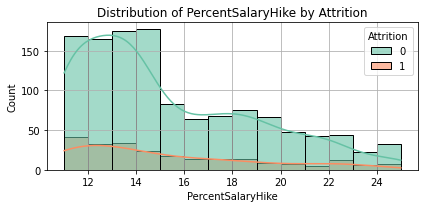

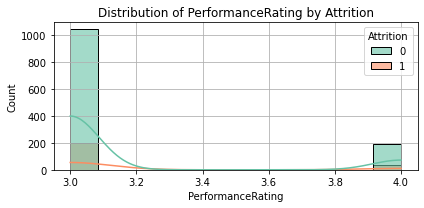

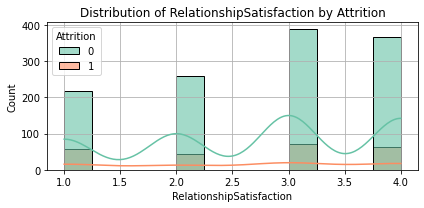

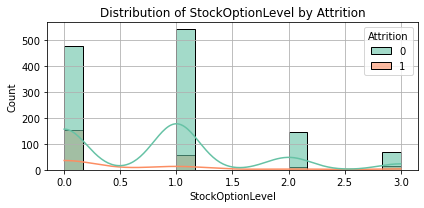

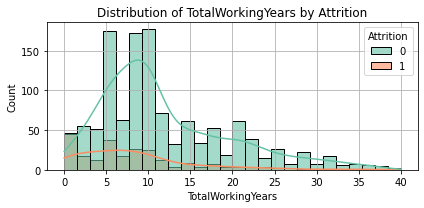

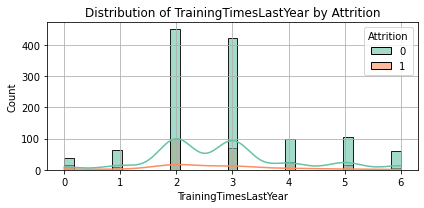

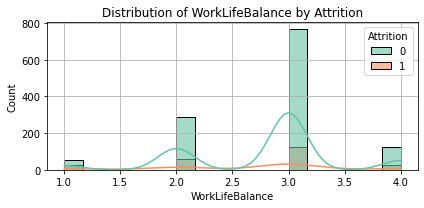

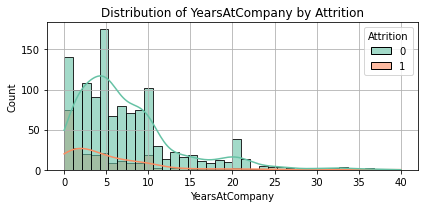

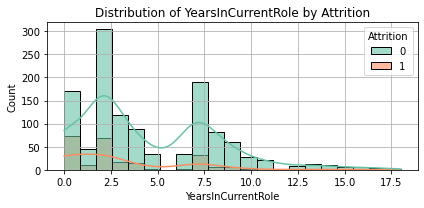

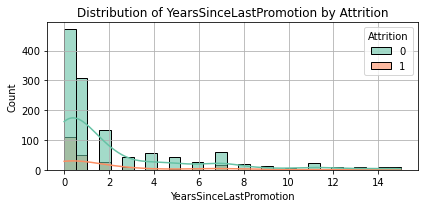

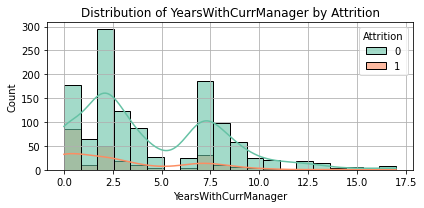

In [41]:
# Distribution plots for all numerical features
excluded_col = 'Attrition'
filtered_columns = [col for col in df_num_col if col != excluded_col]

for c in df_num_col:
    plt.figure(figsize=(6, 3))
    sns.histplot(data=df, x=c, hue=excluded_col, kde=True, stat='count', alpha=0.6, palette='Set2')
    plt.title(f"Distribution of {c} by {excluded_col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



*  JobInvolvement - employees with medium job involvement are more likely to quit.
*  JobLevel - employees at lower job levels are more likely to leave, possibly due to lack of satisfaction, compensation or growth.
*  MonthlyIncome - workers with lower income are more prone to leave the company.
*  StockOptionLevel - no stock options might be a factor contributing to employee leaving.
*  TotalWorkingYears - less experienced employees are mote prone to leaving. They may explore career options or seek better opportunities.
*  YearsIiCurrentRole - short tenure is a red flag. It can indicate role misfit or lack of progression.
*  YearsWithCurrManager - the attrition is more possible for workers who spend less years with current manager.
*  YearsAtCompany - newer employees are at higher risk of attrition. The first few years are critical.










# **Outliers detection**

In [42]:
# Split the data into numerical and categorical columns
num_attr = df.select_dtypes(include='number').columns
cat_attr = df.select_dtypes(include='category').columns

In [43]:
cat_attr

Index(['BusinessTravel', 'Department', 'EducationField', 'JobRole',
       'MaritalStatus'],
      dtype='object')

In [44]:
# Numerical columns to be capped based on distribution on upper sight: YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager
columns = ['YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
df_capped = cap_upper_iqr(df, columns)

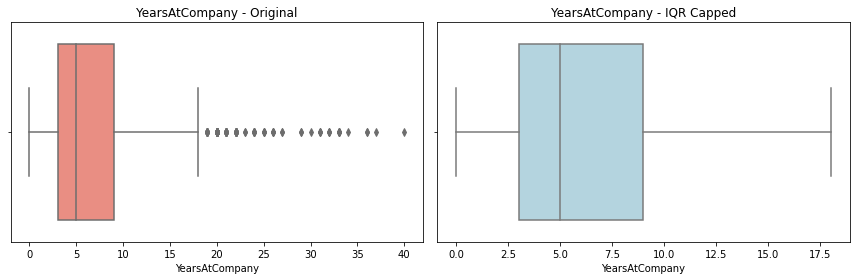

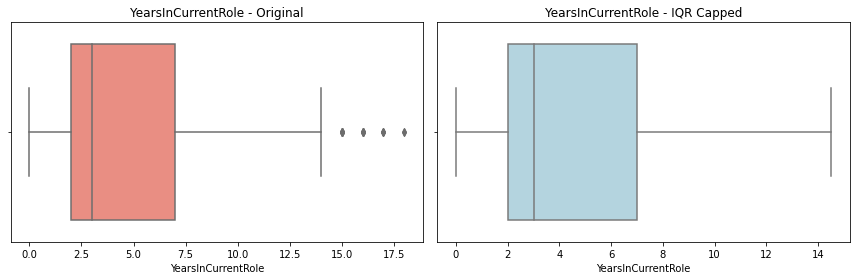

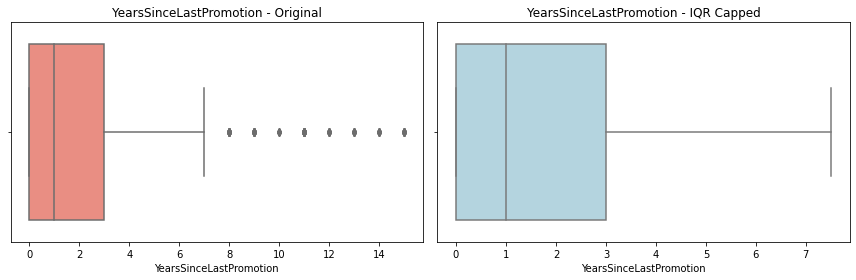

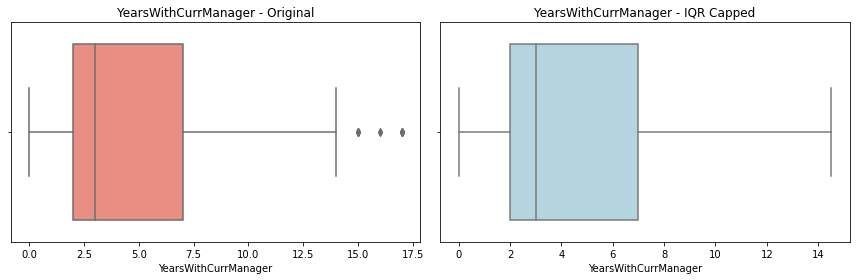

In [45]:
# The comparison for columns before and after capping
for col in columns:
    plt.figure(figsize=(12, 4))

    # Original
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f"{col} - Original")

    # Capped
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_capped[col], color='lightblue')
    plt.title(f"{col} - IQR Capped")

    plt.tight_layout()
    plt.show()

## **Remarks for possible outliers**


*   Columns YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrentManager might have outliers.
* The outliers are floored using first and third quartile for extreme value.  Thanks to this operation for upper bound, the outliers are reduced without removing rows and the dataset size remains constant.


# **Feature Engineering**

In [46]:
# Dataset without MonthlyIncome and other weekly correlated with attrition features
df_shrink = df.drop(columns=['MonthlyIncome', 'NumCompaniesWorked', 'Education', 'Gender', 'YearsSinceLastPromotion', 'MonthlyRate', 'HourlyRate', 'PercentSalaryHike', 'PerformanceRating'])
df_shrink.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'EducationField', 'EnvironmentSatisfaction',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'OverTime', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsWithCurrManager'],
      dtype='object')

In [47]:
# Verify categorical and numerical attributes content for original dataset
print('Numerical attributes:', num_attr)
print('Categorical attributes:', cat_attr)

Numerical attributes: Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')
Categorical attributes: Index(['BusinessTravel', 'Department', 'EducationField', 'JobRole',
       'MaritalStatus'],
      dtype='object')


In [48]:
# Split the shrink data into numerical and categorical columns
num_attr_shrink = df_shrink.select_dtypes(include='number').columns
cat_attr_shrink = df_shrink.select_dtypes(include='category').columns

In [49]:
# Verify categorical and numerical attributes content for shrink dataset
print('Numerical attributes:', num_attr_shrink)
print('Categorical attributes:', cat_attr_shrink)

Numerical attributes: Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome',
       'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'OverTime', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsWithCurrManager'],
      dtype='object')
Categorical attributes: Index(['BusinessTravel', 'Department', 'EducationField', 'JobRole',
       'MaritalStatus'],
      dtype='object')


In [50]:
# Column transformer to preprocess numeric and categorical columns
excluded_column = 'Attrition'
num_attr_except_one = [col for col in num_attr if col != excluded_column]
all_attr = list(num_attr) + list(cat_attr)

num_attr_shrink_except_one = [col for col in num_attr_shrink if col != excluded_column]
all_attr_shrink = list(num_attr_shrink) + list(cat_attr_shrink)

In [51]:
# Column transformer to preprocess numeric and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_attr_except_one),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_attr)
])

preprocessor_shrink = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_attr_shrink_except_one),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_attr_shrink)
])

In [52]:
# Function to get pipeline with any model
def get_model_pipeline(model):
    return SklearnPipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

# **Modellling for original dataset**

In [53]:
# Retrieving columns which will represent independent/dependent variables
X = df.drop(['Attrition'], axis = 1)
y = df[['Attrition']]

In [54]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True, stratify=y, random_state = 111)

## **Logistic Regression model**

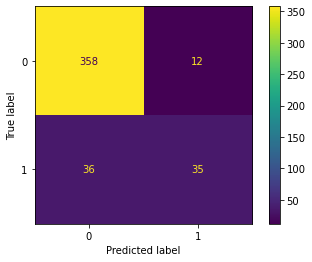

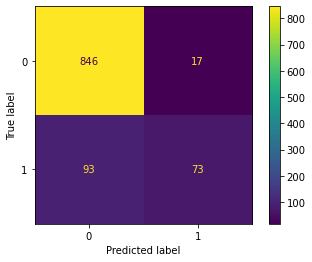

In [55]:
# Logistic regression model
model_1 = get_model_pipeline(LogisticRegression())
model_1.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_1.predict(X_test)
y_pred_tr = model_1.predict(X_train)
# Confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(model_1, X_test, y_test)
# Confusion matrix for train set
ConfusionMatrixDisplay.from_estimator(model_1, X_train, y_train)

In [56]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       370
           1       0.74      0.49      0.59        71

    accuracy                           0.89       441
   macro avg       0.83      0.73      0.77       441
weighted avg       0.88      0.89      0.88       441



In [57]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       863
           1       0.81      0.44      0.57       166

    accuracy                           0.89      1029
   macro avg       0.86      0.71      0.75      1029
weighted avg       0.89      0.89      0.88      1029



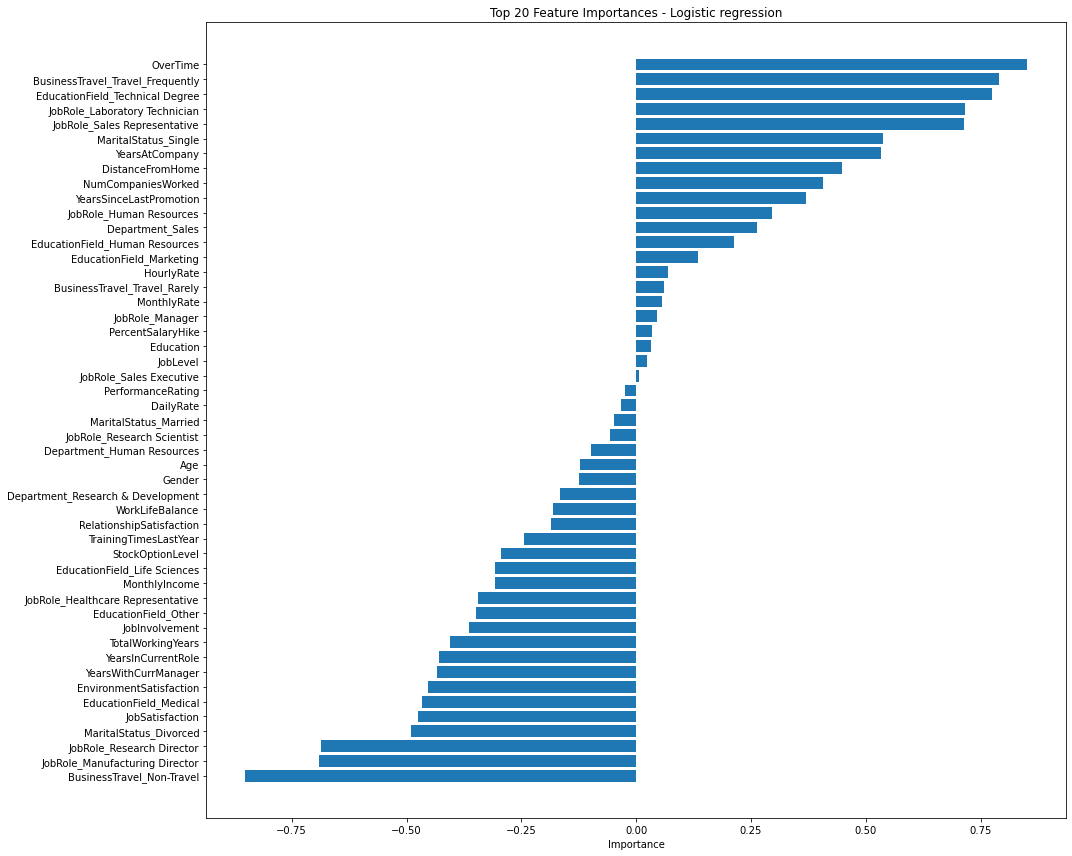

In [58]:
feature_names = []

# Extract feature names from each transformer in the ColumnTransformer
for name, transformer, columns in preprocessor.transformers_:
    if name != 'remainder':
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_names = transformer.get_feature_names_out(columns)
        else:
            transformed_names = columns
        feature_names.extend(transformed_names)

m1 = model_1.named_steps['model']
importances = m1.coef_[0]

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Logistic regression')
plt.tight_layout()
plt.show()


*  We can expect that odds of people who left the company to increase (the original coefficient is positive) for features: OverTime, BusinessTravel_Travel_Frequently, EducationField_Technical Degree, JobRole_Sales Representative, JobRole_Laboratory Technician, YearsAtCompany, MaritalStatus_Single, DistanceFromHome, NumCompaniesWorked, YearsSinceLastPromotion, JobRole_Human Resources, Department_Sales, EducationField_HumanResources, EducationField_Marketing, HourlyRate, MonthlyRate, BusinessTravel_Travel Rarely, JobRole_Manager, PercentSalaryHike, Education, JobLevel and JobRole_Sales Executive.
*   OverTime, BusinessTravel_Travel_Frequently and EducationField_Technical Degree are the strongest predictors.
*   PerformanceRating and JobRole_Sales Executive are the weakest predictors.






In [59]:
# Gather some metrics for future comparison of models performance
metrics_1 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

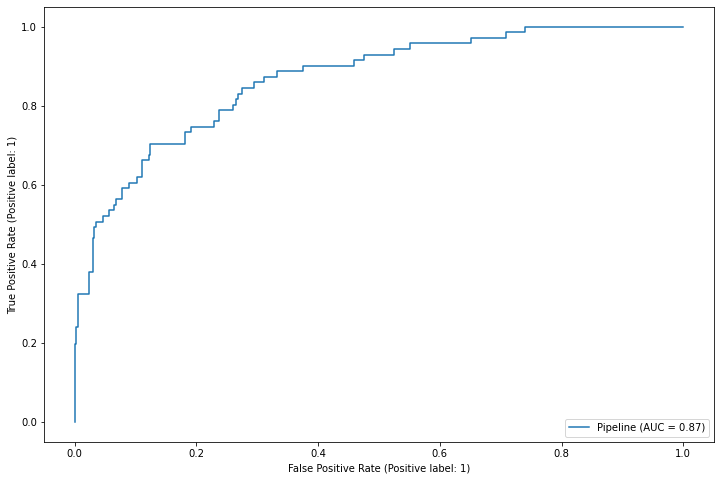

In [60]:
# ROC curve
plot_roc_curve(model_1, X_test, y_test)

AUC is 0.87 which means that there is a 87% chance that the model will be able to distinguish between positive class and negative class.

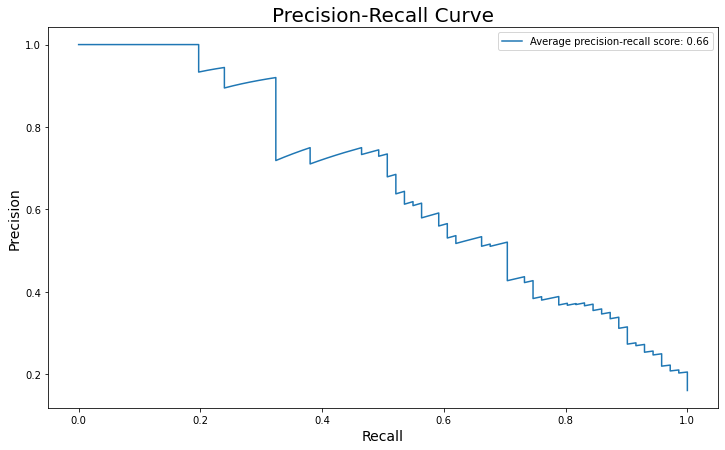

In [61]:
# Precision-Recall curve
plot_precision_recall_curve(model_1, X_test, y_test)

In [62]:
# Row with model
row_1 = create_model_summary_row("Logistic Regression", metrics_1)

## **Random Forest model**

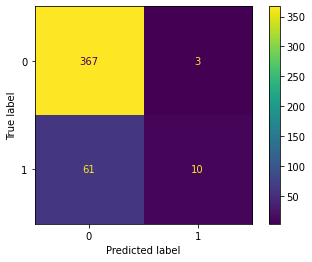

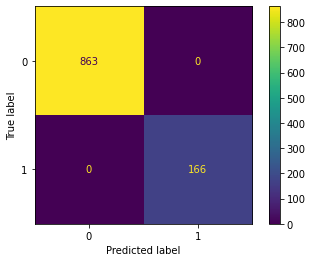

In [63]:
# Random Forest Classifier model
model_2 = get_model_pipeline(RandomForestClassifier())
model_2.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_2.predict(X_test)
y_pred_tr = model_2.predict(X_train)
# Confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(model_2, X_test, y_test)
# Confusion matrix for train set
ConfusionMatrixDisplay.from_estimator(model_2, X_train, y_train)

In [64]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       370
           1       0.77      0.14      0.24        71

    accuracy                           0.85       441
   macro avg       0.81      0.57      0.58       441
weighted avg       0.84      0.85      0.81       441



In [65]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       166

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029



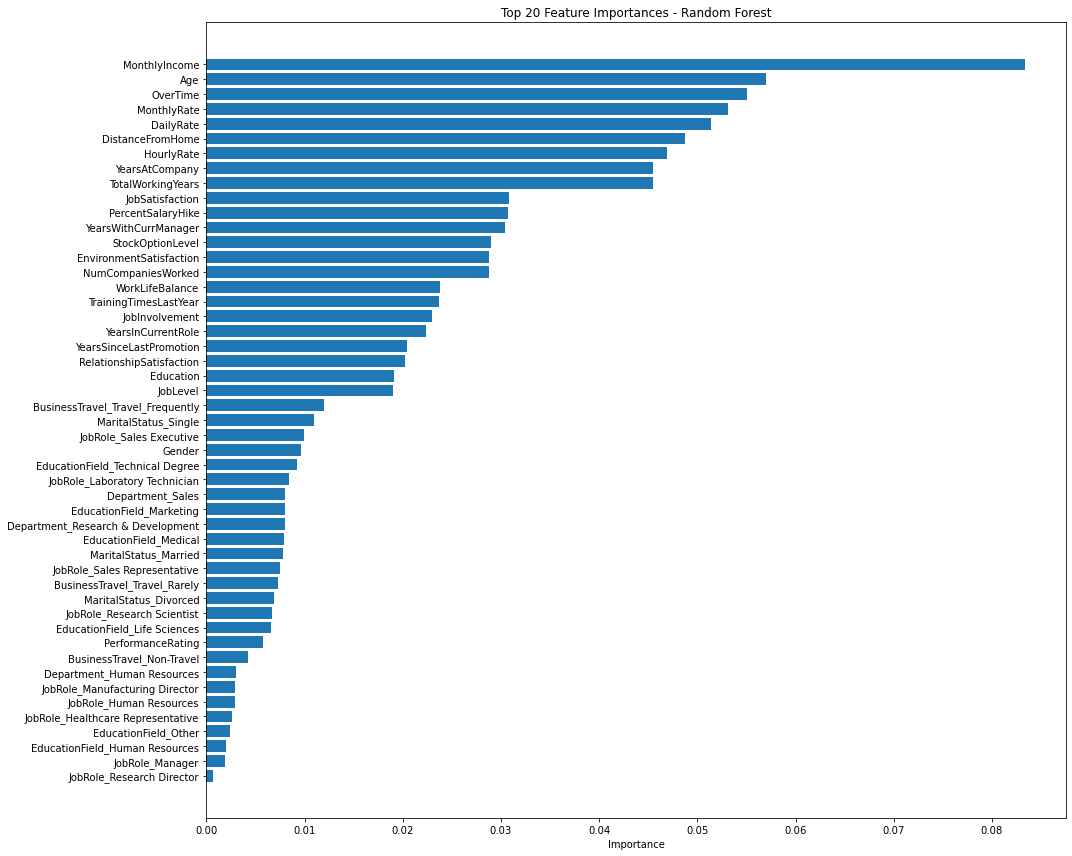

In [66]:
feature_importance_df = get_feature_importance_df(model_2, preprocessor)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()


*   We can expect the odds of people who left to increase (the original coeff was positive) for all features.
*   OverTime, MonthlyIncome and Age are the strongest predictors.
*  JobRole_Research Director and Department_Human Resources are the weakest predictors.








In [67]:
# Gather some metrics for future comparison of models performance
metrics_2 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

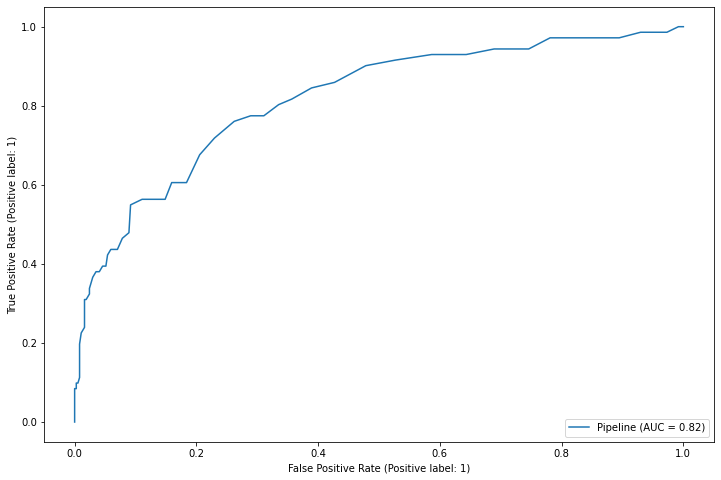

In [68]:
# ROC curve
plot_roc_curve(model_2, X_test, y_test)

AUC is 0.83 which means that there is a 83% chance that the model will be able to distinguish between positive class and negative class.

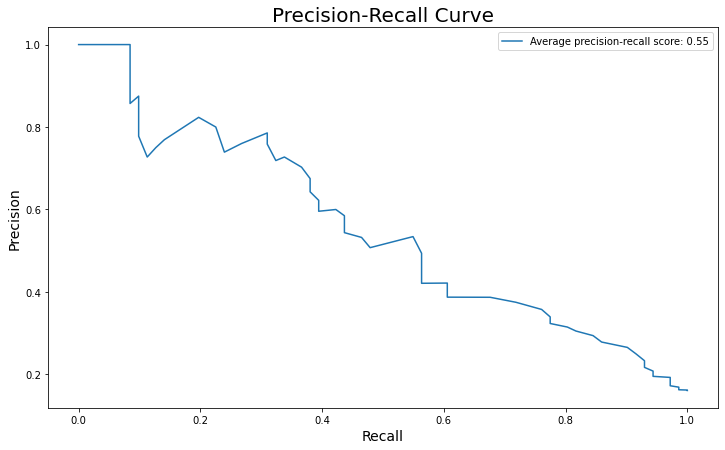

In [69]:
# Precision-Recall curve
plot_precision_recall_curve(model_2, X_test, y_test)

In [70]:
# Row with model
row_2 = create_model_summary_row("Random Forest", metrics_2)

## **Decision tree model**

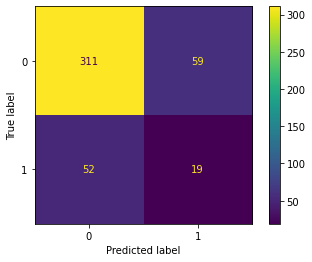

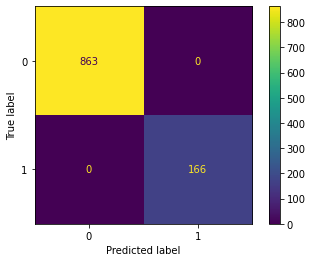

In [71]:
# DecisionTree Classifier model
model_3 = get_model_pipeline(DecisionTreeClassifier())
model_3.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_3.predict(X_test)
y_pred_tr = model_3.predict(X_train)
# Confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(model_3, X_test, y_test)
# Confusion matrix for train set
ConfusionMatrixDisplay.from_estimator(model_3, X_train, y_train)

In [72]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       370
           1       0.24      0.27      0.26        71

    accuracy                           0.75       441
   macro avg       0.55      0.55      0.55       441
weighted avg       0.76      0.75      0.75       441



In [73]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       166

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029



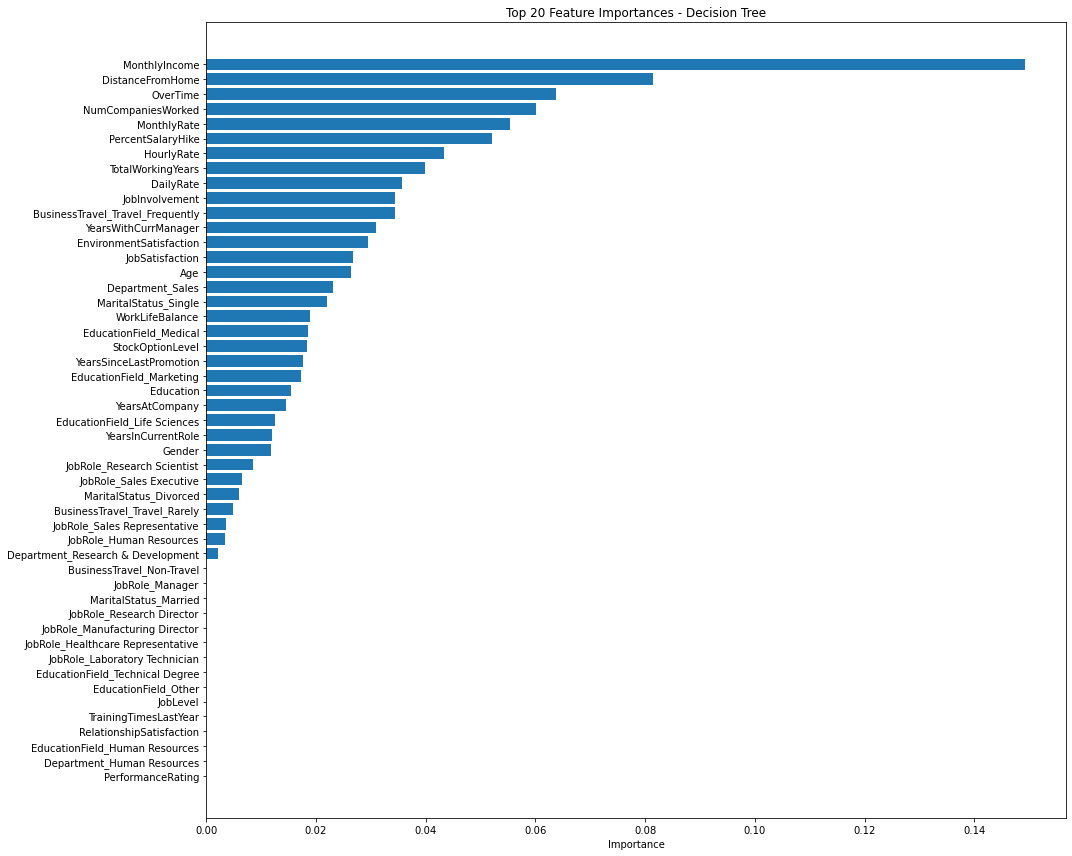

In [74]:
feature_importance_df = get_feature_importance_df(model_3, preprocessor)
# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Decision Tree')
plt.tight_layout()
plt.show()


*   We can expect the odds of people who left to increase (the original coeff was positive) for MonthlyIncome, OverTime, DistanceFromHome, NumCompaniesWorked, BusinessTravel_Travel_Frequently, TotalWorkingYears, StockOptionLevel, MaritalStatus_Single, Department_Sales, EnvironmentSatisfaction, DailyRate, EducationField_Marketing, JobInvolvement, YearsSincdLastPromotion, YearsAtCompany, Gender, HourlyRate, Department_Research & Development, PercentSalaryHike, TrainingTimesLastYear.
*   Rest columns have coeff equals zero.
*   MonthlyIncome is the strongest predictor.





In [75]:
# Gather some metrics for future comparison of models performance
metrics_3 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

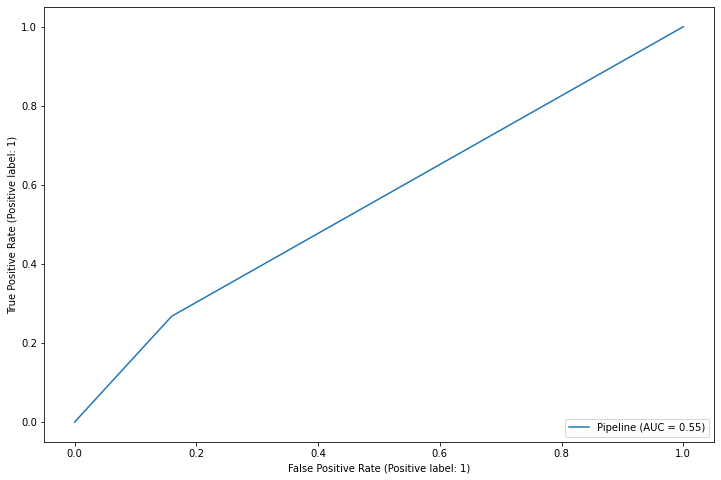

In [76]:
# ROC curve
plot_roc_curve(model_3, X_test, y_test)

AUC is 0.57 which means that there is a 57% chance that the model will be able to distinguish between positive class and negative class.

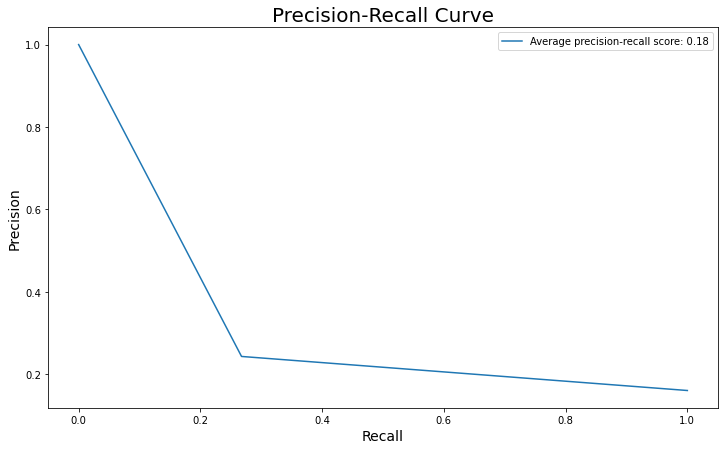

In [77]:
# Precision-Recall curve
plot_precision_recall_curve(model_3, X_test, y_test)

In [78]:
# Row with model
row_3 = create_model_summary_row("Decision Tree", metrics_3)

## **AdaBoost model**

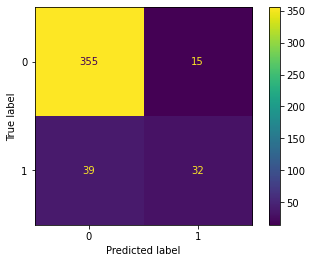

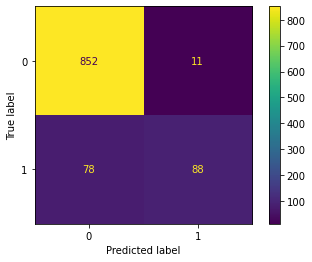

In [79]:
#  AdaBoost Classifier model
model_4 = get_model_pipeline(AdaBoostClassifier())
model_4.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_4.predict(X_test)
y_pred_tr = model_4.predict(X_train)
# Confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(model_4, X_test, y_test)
# Confusion matrix for train set
ConfusionMatrixDisplay.from_estimator(model_4, X_train, y_train)

In [80]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       370
           1       0.68      0.45      0.54        71

    accuracy                           0.88       441
   macro avg       0.79      0.71      0.74       441
weighted avg       0.87      0.88      0.87       441



In [81]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       863
           1       0.89      0.53      0.66       166

    accuracy                           0.91      1029
   macro avg       0.90      0.76      0.81      1029
weighted avg       0.91      0.91      0.90      1029



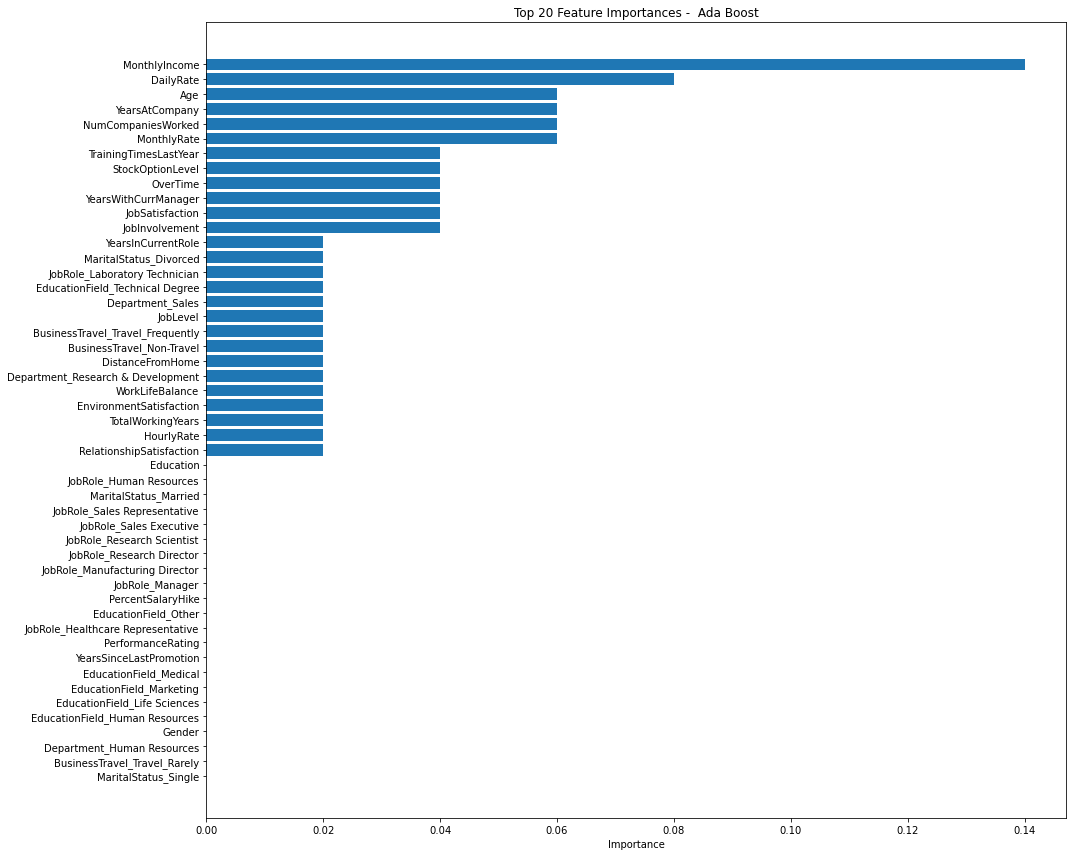

In [82]:
feature_importance_df = get_feature_importance_df(model_4, preprocessor)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances -  Ada Boost')
plt.tight_layout()
plt.show()

* We can expect the odds of people who left the company to increase (the original coeff was positive) for OverTime, YearsWithCurrManeger, MonthlyIncome, JobSatisfaction, YearsAtCompany, StockOptionLevel, HourlyRate, RelationshipSatisfaction, EnvironmentSatisfaction, Age, DistanceFromHome, JobInvolvement, Department_Research & Development, TrainingTmesLastYear, EducationField_Technical Degree, JobLevel, JobRole_Laboratory Technician, Department_Sales, BusinessTravel_Travel_Frequently, NumCompaniesWorked, BusinessTravel_Non-Travel.
* Remaining features had coeff equals zero.
* OverTime and YearsWithCurrManager are the strongest predictors.

In [83]:
# Gather some metrics for future comparison of models performance
metrics_4 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

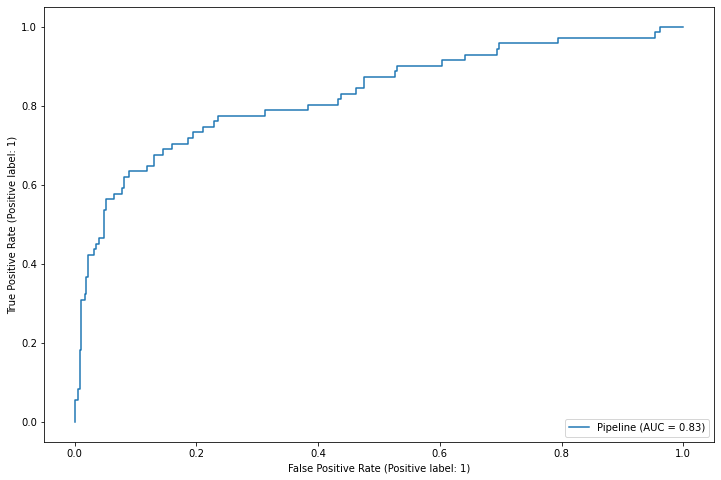

In [84]:
# ROC curve
plot_roc_curve(model_4, X_test, y_test)

AUC is 0.82 which means that there is a 82% chance that the model will be able to distinguish between positive class and negative class.

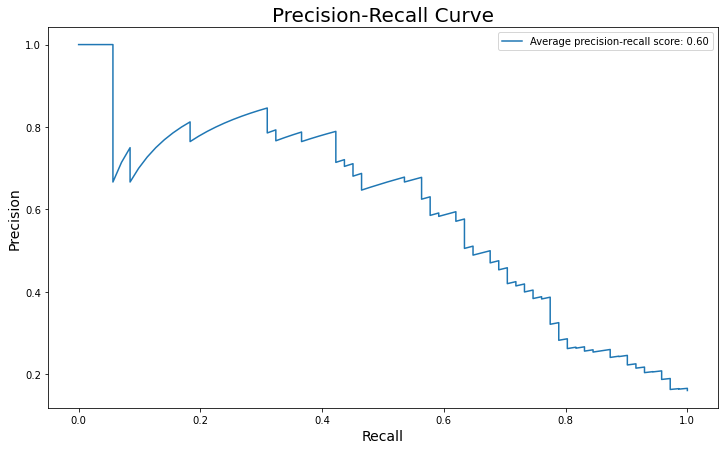

In [85]:
# Precision-Recall curve
plot_precision_recall_curve(model_4, X_test, y_test)

In [86]:
# Row with model
row_4 = create_model_summary_row("Ada Boost", metrics_4)

## **Gradient Boosting model**

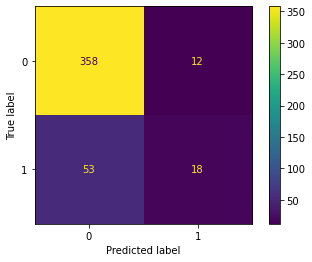

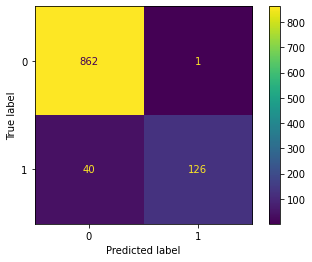

In [87]:
# Gradient Boosting model
model_5 = get_model_pipeline(GradientBoostingClassifier())
model_5.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_5.predict(X_test)
y_pred_tr = model_5.predict(X_train)
# Confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(model_5, X_test, y_test)
# Confusion matrix for train set
ConfusionMatrixDisplay.from_estimator(model_5, X_train, y_train)

In [88]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       370
           1       0.60      0.25      0.36        71

    accuracy                           0.85       441
   macro avg       0.74      0.61      0.64       441
weighted avg       0.83      0.85      0.83       441



In [89]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       863
           1       0.99      0.76      0.86       166

    accuracy                           0.96      1029
   macro avg       0.97      0.88      0.92      1029
weighted avg       0.96      0.96      0.96      1029



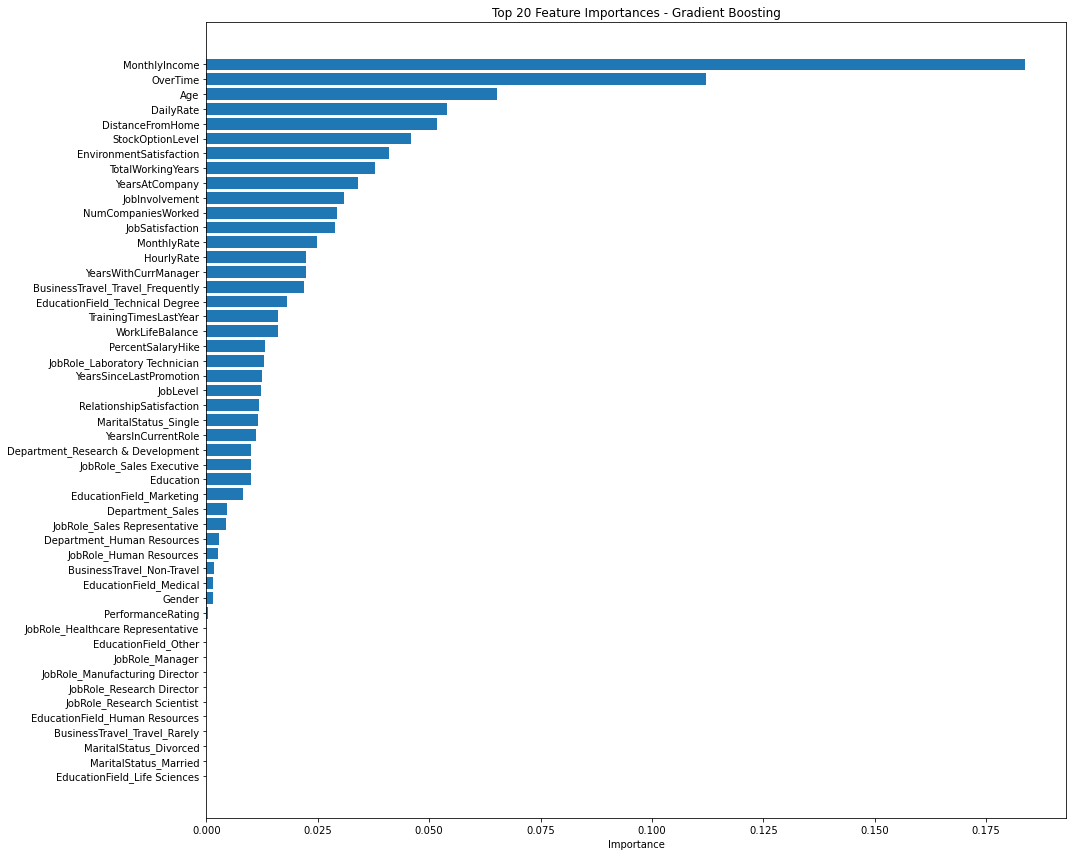

In [90]:
feature_importance_df = get_feature_importance_df(model_5, preprocessor)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Gradient Boosting')
plt.tight_layout()
plt.show()

* We can expect the odds of workers who left to increase (the original coeff was positive) for almost all features.
* PerformanceRating, EducationField_Life Sciences,
BusinessTravel_Travel Rarely, EducationField_Human Resources,
JobRole_Manager,
JobRole_Human Resources,
JobRole_Healthcare Representative, EducationField_Other,
JobRole_Manufacturing Director,
JobRole_Research Scientist,
JobRole_Research Director,
MaritalStatus_Divorced,
MaritalStatus_Married had coeff zero.
* MontlyIncome and OverTime are the strongest predictors.

In [91]:
# Gather some metrics for future comparison of models performance
metrics_5 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

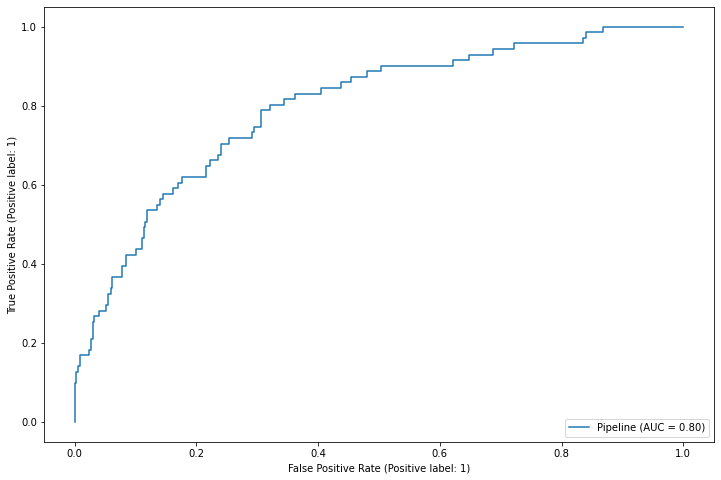

In [92]:
# ROC curve
plot_roc_curve(model_5, X_test, y_test)

AUC is 0.80 which means that there is a 80% chance that the model will be able to distinguish between positive class and negative class.

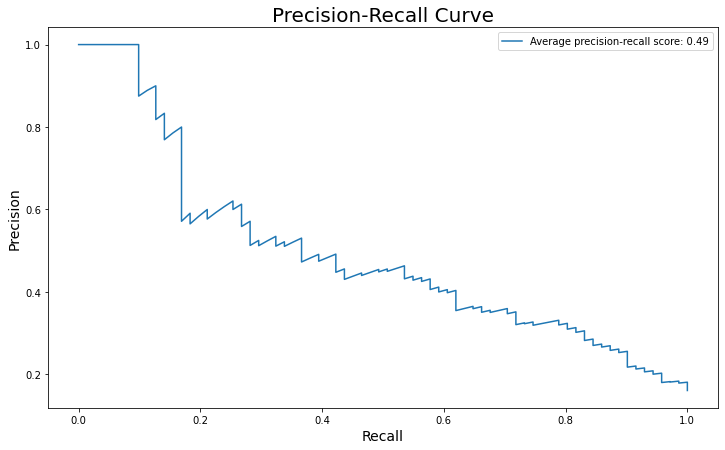

In [93]:
# Precision-Recall curve
plot_precision_recall_curve(model_5, X_test, y_test)

In [94]:
# Row with model
row_5 = create_model_summary_row("Gradeint Boosting", metrics_5)

## **XGBoosing model**

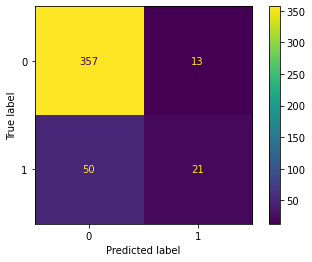

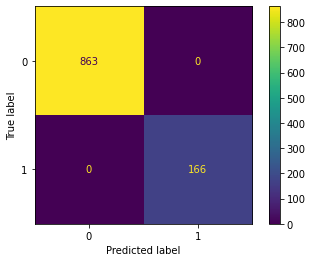

In [95]:
# XGB model
model_6 = get_model_pipeline(XGBClassifier())
model_6.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_6.predict(X_test)
y_pred_tr = model_6.predict(X_train)
# Confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(model_6, X_test, y_test)
# Confusion matrix for train set
ConfusionMatrixDisplay.from_estimator(model_6, X_train, y_train)

In [96]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       370
           1       0.62      0.30      0.40        71

    accuracy                           0.86       441
   macro avg       0.75      0.63      0.66       441
weighted avg       0.84      0.86      0.84       441



In [97]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       166

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029



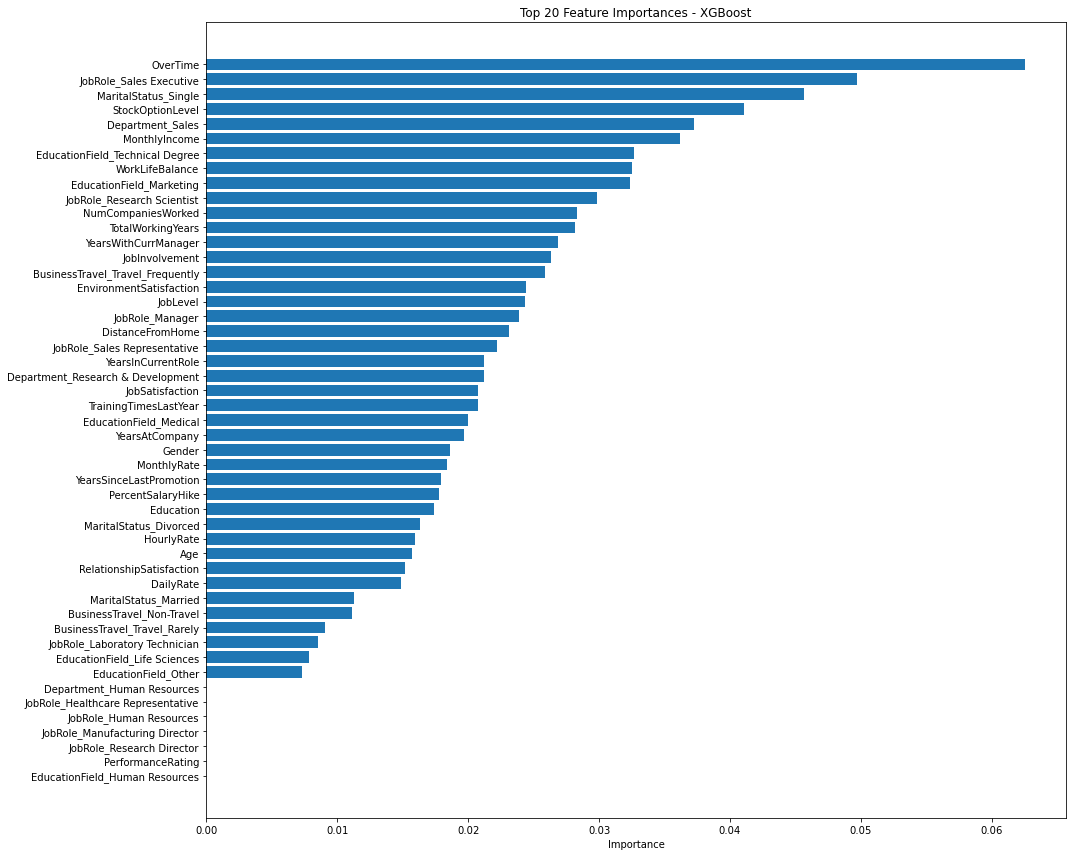

In [98]:
feature_importance_df = get_feature_importance_df(model_6, preprocessor)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()

* We can expect the odds of people who left to increase (the original coeff was positive) for almost all features.
* PerformanceRating, EducationField_Human Resources, Department_Human Resources, JobRole_Healthcare Representative, JobRole_Human Resources, JobRole_Manufacturing Director and JobRole_Research Director have coeff equals to zero.
* Overtime and JobRole_Sales Executive are the strongest predictors.

In [99]:
# Gather some metrics for future comparison of models performance
metrics_6 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

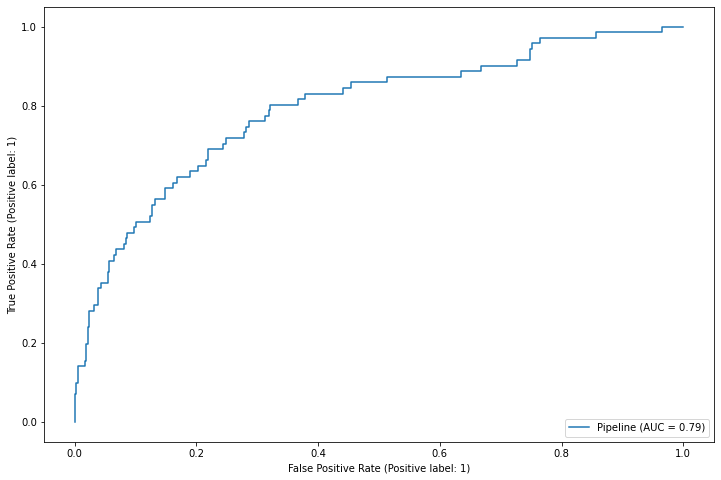

In [100]:
# ROC curve
plot_roc_curve(model_6, X_test, y_test)

AUC is 0.79 which means that there is a 79% chance that the model will be able to distinguish between positive class and negative class.

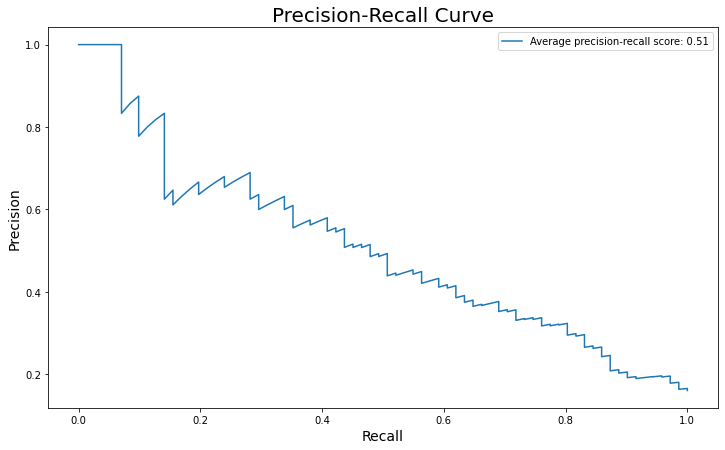

In [101]:
# Precision-Recall curve
plot_precision_recall_curve(model_6, X_test, y_test)

In [102]:
# Row with model
row_6 = create_model_summary_row("XGBoosting", metrics_6)

## **CatBoost model**

In [103]:
# CatBoost classifier model
model_7 = get_model_pipeline(CatBoostClassifier())
model_7.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_7.predict(X_test)
y_pred_tr = model_7.predict(X_train)

Learning rate set to 0.010429
0:	learn: 0.6850725	total: 168ms	remaining: 2m 48s
1:	learn: 0.6769945	total: 173ms	remaining: 1m 26s
2:	learn: 0.6703725	total: 185ms	remaining: 1m 1s
3:	learn: 0.6628185	total: 190ms	remaining: 47.2s
4:	learn: 0.6564501	total: 195ms	remaining: 38.8s
5:	learn: 0.6497075	total: 198ms	remaining: 32.8s
6:	learn: 0.6434945	total: 202ms	remaining: 28.6s
7:	learn: 0.6363787	total: 206ms	remaining: 25.6s
8:	learn: 0.6294561	total: 213ms	remaining: 23.4s
9:	learn: 0.6240257	total: 217ms	remaining: 21.4s
10:	learn: 0.6187167	total: 220ms	remaining: 19.8s
11:	learn: 0.6127126	total: 225ms	remaining: 18.5s
12:	learn: 0.6059208	total: 228ms	remaining: 17.3s
13:	learn: 0.6015605	total: 230ms	remaining: 16.2s
14:	learn: 0.5960101	total: 234ms	remaining: 15.4s
15:	learn: 0.5894462	total: 238ms	remaining: 14.7s
16:	learn: 0.5844314	total: 244ms	remaining: 14.1s
17:	learn: 0.5796561	total: 247ms	remaining: 13.5s
18:	learn: 0.5732973	total: 251ms	remaining: 13s
19:	learn: 

184:	learn: 0.2884620	total: 1.04s	remaining: 4.57s
185:	learn: 0.2878279	total: 1.04s	remaining: 4.56s
186:	learn: 0.2871045	total: 1.05s	remaining: 4.55s
187:	learn: 0.2863048	total: 1.05s	remaining: 4.54s
188:	learn: 0.2858671	total: 1.05s	remaining: 4.53s
189:	learn: 0.2853199	total: 1.06s	remaining: 4.51s
190:	learn: 0.2848425	total: 1.06s	remaining: 4.5s
191:	learn: 0.2842807	total: 1.07s	remaining: 4.5s
192:	learn: 0.2837778	total: 1.07s	remaining: 4.48s
193:	learn: 0.2832549	total: 1.07s	remaining: 4.47s
194:	learn: 0.2825240	total: 1.08s	remaining: 4.46s
195:	learn: 0.2818267	total: 1.08s	remaining: 4.45s
196:	learn: 0.2814644	total: 1.09s	remaining: 4.43s
197:	learn: 0.2809486	total: 1.09s	remaining: 4.42s
198:	learn: 0.2802306	total: 1.09s	remaining: 4.4s
199:	learn: 0.2794965	total: 1.1s	remaining: 4.4s
200:	learn: 0.2789728	total: 1.1s	remaining: 4.39s
201:	learn: 0.2784554	total: 1.11s	remaining: 4.38s
202:	learn: 0.2779534	total: 1.11s	remaining: 4.37s
203:	learn: 0.2774

346:	learn: 0.2214120	total: 1.72s	remaining: 3.23s
347:	learn: 0.2211911	total: 1.72s	remaining: 3.23s
348:	learn: 0.2207675	total: 1.73s	remaining: 3.22s
349:	learn: 0.2204029	total: 1.73s	remaining: 3.22s
350:	learn: 0.2201975	total: 1.74s	remaining: 3.22s
351:	learn: 0.2198307	total: 1.74s	remaining: 3.21s
352:	learn: 0.2194949	total: 1.75s	remaining: 3.21s
353:	learn: 0.2192144	total: 1.75s	remaining: 3.2s
354:	learn: 0.2189587	total: 1.76s	remaining: 3.19s
355:	learn: 0.2185652	total: 1.76s	remaining: 3.19s
356:	learn: 0.2182233	total: 1.77s	remaining: 3.18s
357:	learn: 0.2179532	total: 1.77s	remaining: 3.17s
358:	learn: 0.2175851	total: 1.77s	remaining: 3.17s
359:	learn: 0.2174153	total: 1.78s	remaining: 3.16s
360:	learn: 0.2170338	total: 1.78s	remaining: 3.16s
361:	learn: 0.2168053	total: 1.79s	remaining: 3.15s
362:	learn: 0.2166571	total: 1.79s	remaining: 3.14s
363:	learn: 0.2162392	total: 1.79s	remaining: 3.14s
364:	learn: 0.2159214	total: 1.8s	remaining: 3.13s
365:	learn: 0.

541:	learn: 0.1723048	total: 2.57s	remaining: 2.17s
542:	learn: 0.1718855	total: 2.58s	remaining: 2.17s
543:	learn: 0.1718026	total: 2.58s	remaining: 2.16s
544:	learn: 0.1716118	total: 2.58s	remaining: 2.16s
545:	learn: 0.1714063	total: 2.59s	remaining: 2.15s
546:	learn: 0.1711855	total: 2.59s	remaining: 2.15s
547:	learn: 0.1709652	total: 2.6s	remaining: 2.14s
548:	learn: 0.1707300	total: 2.6s	remaining: 2.14s
549:	learn: 0.1705027	total: 2.6s	remaining: 2.13s
550:	learn: 0.1703120	total: 2.61s	remaining: 2.13s
551:	learn: 0.1701758	total: 2.61s	remaining: 2.12s
552:	learn: 0.1698479	total: 2.62s	remaining: 2.11s
553:	learn: 0.1696760	total: 2.62s	remaining: 2.11s
554:	learn: 0.1693387	total: 2.62s	remaining: 2.1s
555:	learn: 0.1690789	total: 2.63s	remaining: 2.1s
556:	learn: 0.1688251	total: 2.63s	remaining: 2.09s
557:	learn: 0.1686878	total: 2.63s	remaining: 2.09s
558:	learn: 0.1684870	total: 2.64s	remaining: 2.08s
559:	learn: 0.1682697	total: 2.64s	remaining: 2.08s
560:	learn: 0.168

722:	learn: 0.1361851	total: 3.43s	remaining: 1.31s
723:	learn: 0.1360662	total: 3.43s	remaining: 1.31s
724:	learn: 0.1358640	total: 3.44s	remaining: 1.3s
725:	learn: 0.1356152	total: 3.45s	remaining: 1.3s
726:	learn: 0.1354835	total: 3.45s	remaining: 1.29s
727:	learn: 0.1354259	total: 3.46s	remaining: 1.29s
728:	learn: 0.1353343	total: 3.46s	remaining: 1.29s
729:	learn: 0.1350289	total: 3.46s	remaining: 1.28s
730:	learn: 0.1348188	total: 3.47s	remaining: 1.28s
731:	learn: 0.1347286	total: 3.48s	remaining: 1.27s
732:	learn: 0.1346080	total: 3.48s	remaining: 1.27s
733:	learn: 0.1344070	total: 3.48s	remaining: 1.26s
734:	learn: 0.1343620	total: 3.49s	remaining: 1.26s
735:	learn: 0.1342352	total: 3.49s	remaining: 1.25s
736:	learn: 0.1340611	total: 3.5s	remaining: 1.25s
737:	learn: 0.1338952	total: 3.5s	remaining: 1.24s
738:	learn: 0.1336280	total: 3.51s	remaining: 1.24s
739:	learn: 0.1333965	total: 3.51s	remaining: 1.23s
740:	learn: 0.1331916	total: 3.52s	remaining: 1.23s
741:	learn: 0.13

915:	learn: 0.1061961	total: 4.29s	remaining: 393ms
916:	learn: 0.1060310	total: 4.29s	remaining: 389ms
917:	learn: 0.1058473	total: 4.3s	remaining: 384ms
918:	learn: 0.1056908	total: 4.3s	remaining: 379ms
919:	learn: 0.1054782	total: 4.31s	remaining: 374ms
920:	learn: 0.1052667	total: 4.31s	remaining: 370ms
921:	learn: 0.1051062	total: 4.31s	remaining: 365ms
922:	learn: 0.1050611	total: 4.32s	remaining: 360ms
923:	learn: 0.1049540	total: 4.32s	remaining: 355ms
924:	learn: 0.1048650	total: 4.33s	remaining: 351ms
925:	learn: 0.1047568	total: 4.33s	remaining: 346ms
926:	learn: 0.1046760	total: 4.33s	remaining: 341ms
927:	learn: 0.1044696	total: 4.34s	remaining: 337ms
928:	learn: 0.1044006	total: 4.34s	remaining: 332ms
929:	learn: 0.1042526	total: 4.35s	remaining: 327ms
930:	learn: 0.1040532	total: 4.35s	remaining: 322ms
931:	learn: 0.1038964	total: 4.35s	remaining: 318ms
932:	learn: 0.1038161	total: 4.36s	remaining: 313ms
933:	learn: 0.1036616	total: 4.36s	remaining: 308ms
934:	learn: 0.

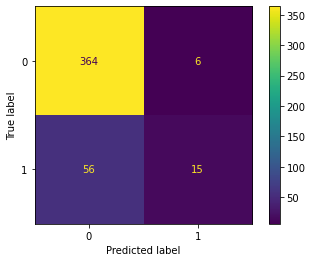

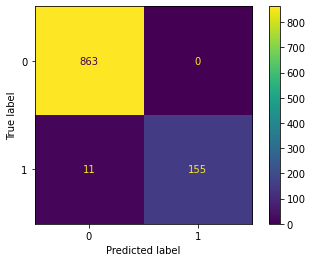

In [104]:
# Confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(model_7, X_test, y_test)
# Confusion matrix for train set
ConfusionMatrixDisplay.from_estimator(model_7, X_train, y_train)

In [105]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       370
           1       0.71      0.21      0.33        71

    accuracy                           0.86       441
   macro avg       0.79      0.60      0.62       441
weighted avg       0.84      0.86      0.83       441



In [106]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       863
           1       1.00      0.93      0.97       166

    accuracy                           0.99      1029
   macro avg       0.99      0.97      0.98      1029
weighted avg       0.99      0.99      0.99      1029



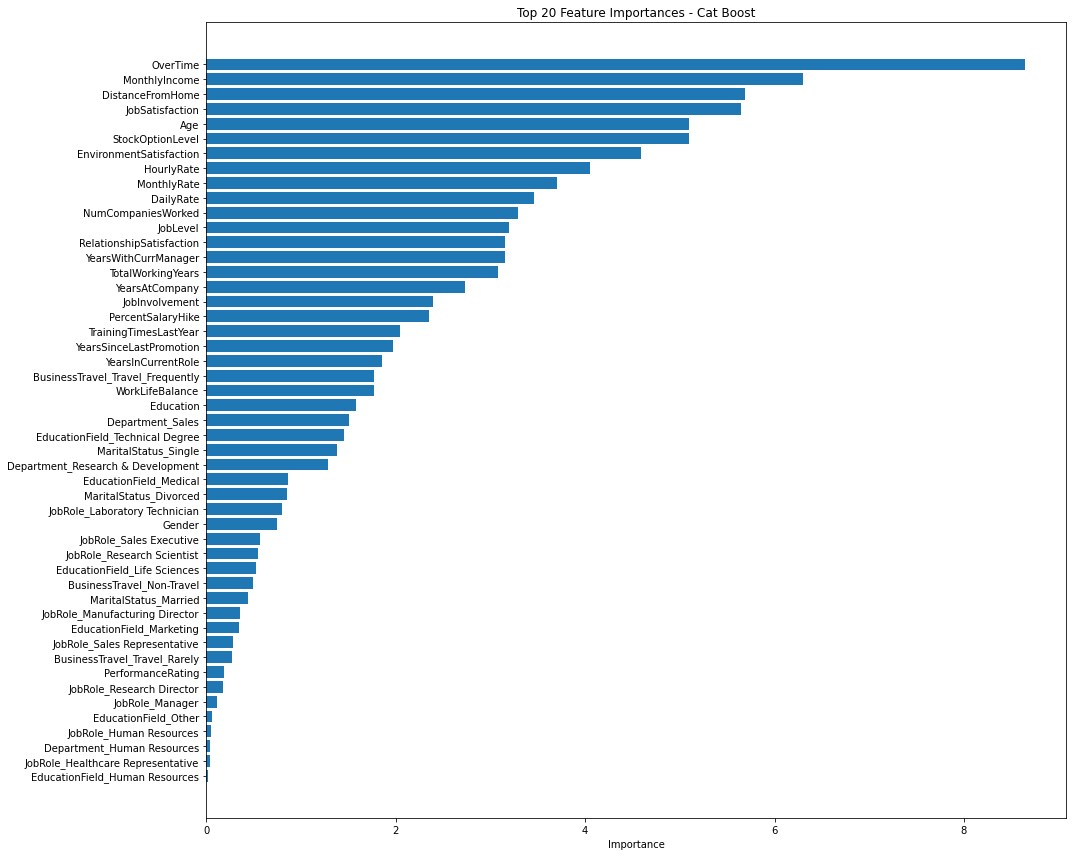

In [107]:
feature_importance_df = get_feature_importance_df(model_7, preprocessor)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Cat Boost')
plt.tight_layout()
plt.show()

* We can expect the odds of people who left to increase (the original coeff was positive) for almost all features.
* EducationField_Human Resources has coeff equals to zero.
* OverTime, MonthlyIncome and Age are the strongest predictors.

In [108]:
# Gather some metrics for future comparison of models performance
metrics_7 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

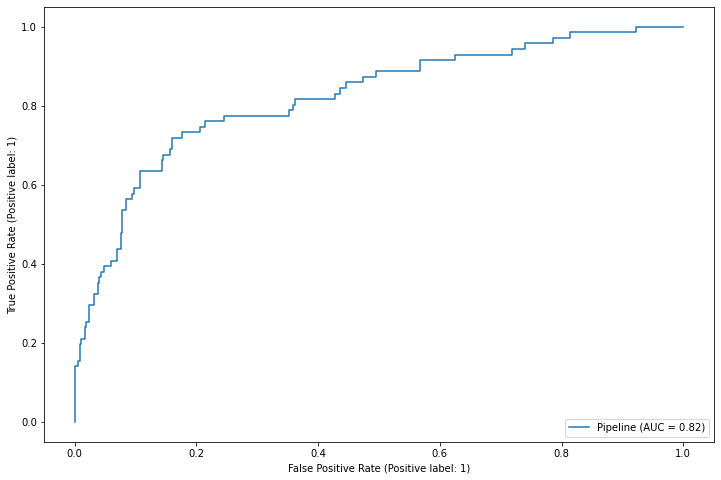

In [109]:
# ROC curve
plot_roc_curve(model_7, X_test, y_test)

AUC is 0.82 which means that there is a 82% chance that the model will be able to distinguish between positive class and negative class.

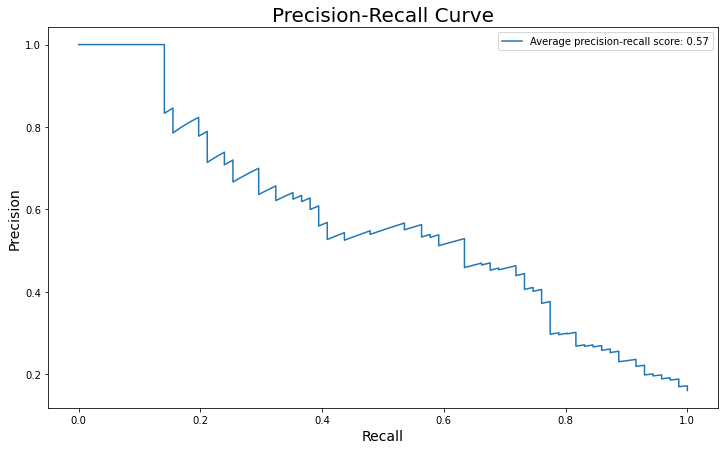

In [110]:
# Precision-Recall curve
plot_precision_recall_curve(model_7, X_test, y_test)

In [111]:
# Row with model
row_7 = create_model_summary_row("CatBoost", metrics_7)

## **Model summary**

In [112]:
# Add all results to dataframe
results = pd.DataFrame(columns=['model', 'tp', 'tn', 'fp', 'fn', 'correct', 'incorrect',
                                  'accuracy_train', 'accuracy_test', 'precision_train', 'precision_test', 'recall_train', 'recall_test', 'f1_train', 'f1_test', 'roc_auc', 'avg_pre'])
new_rows = pd.DataFrame([row_1, row_2, row_3, row_4, row_5, row_6, row_7])
results = pd.concat([results, new_rows], ignore_index=True)
results

,model,tp,tn,fp,fn,correct,incorrect,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,roc_auc,avg_pre
0,Logistic Regression,35,358,12,36,393,48,0.893100,0.891156,0.811111,0.744681,0.439759,0.492958,0.570312,0.593220,0.730263,0.449
1,Random Forest,10,367,3,61,377,64,1.000000,0.854875,1.000000,0.769231,1.000000,0.140845,1.000000,0.238095,0.566368,0.247
2,Decision Tree,19,311,59,52,330,111,1.000000,0.748299,1.000000,0.243590,1.000000,0.267606,1.000000,0.255034,0.554073,0.183
3,Ada Boost,32,355,15,39,387,54,0.913508,0.877551,0.888889,0.680851,0.530120,0.450704,0.664151,0.542373,0.705082,0.395
4,Gradeint Boosting,18,358,12,53,376,65,0.960155,0.852608,0.992126,0.600000,0.759036,0.253521,0.860068,0.356436,0.610544,0.272
5,XGBoosting,21,357,13,50,378,63,1.000000,0.857143,1.000000,0.617647,1.000000,0.295775,1.000000,0.400000,0.630320,0.296
6,CatBoost,15,364,6,56,379,62,0.989310,0.859410,1.000000,0.714286,0.933735,0.211268,0.965732,0.326087,0.597526,0.278


## **Genaral overwiew of models**

* Logistic Regression performs the best overall with a strong balance between precision and recall, making it the most robust choice. It is well-suited for imbalanced classification with minimal overfitting.

* Random Forest is overfitting—perfect precision on train and test, but almost no true positives captured (low recall). Poor generalization and poor F1.

* Single tree is underperforming. Although interpretable, it lacks predictive power and likely overfits.

* AdaBoost is precise but fails to capture actual attrition cases (low recall). Performs similarly to Random Forest but worse than Logistic Regression.

* Gradient Boosting - decent recall and ROC AUC, better than AdaBoost, but still significantly underperforms compared to Logistic Regression. Potential for improvement with tuning.

* XGBoost shows promise—balanced performance and better recall than other tree-based models. Still trails behind Logistic Regression in F1 and ROC AUC.

* CatBoost is stable and good at precision but lacks strong recall. Similar to AdaBoost and Gradient Boosting.

# **To sum up, Logistic Regression will be taken into account in further analysis.**


# **Logistic regression with undersampling**

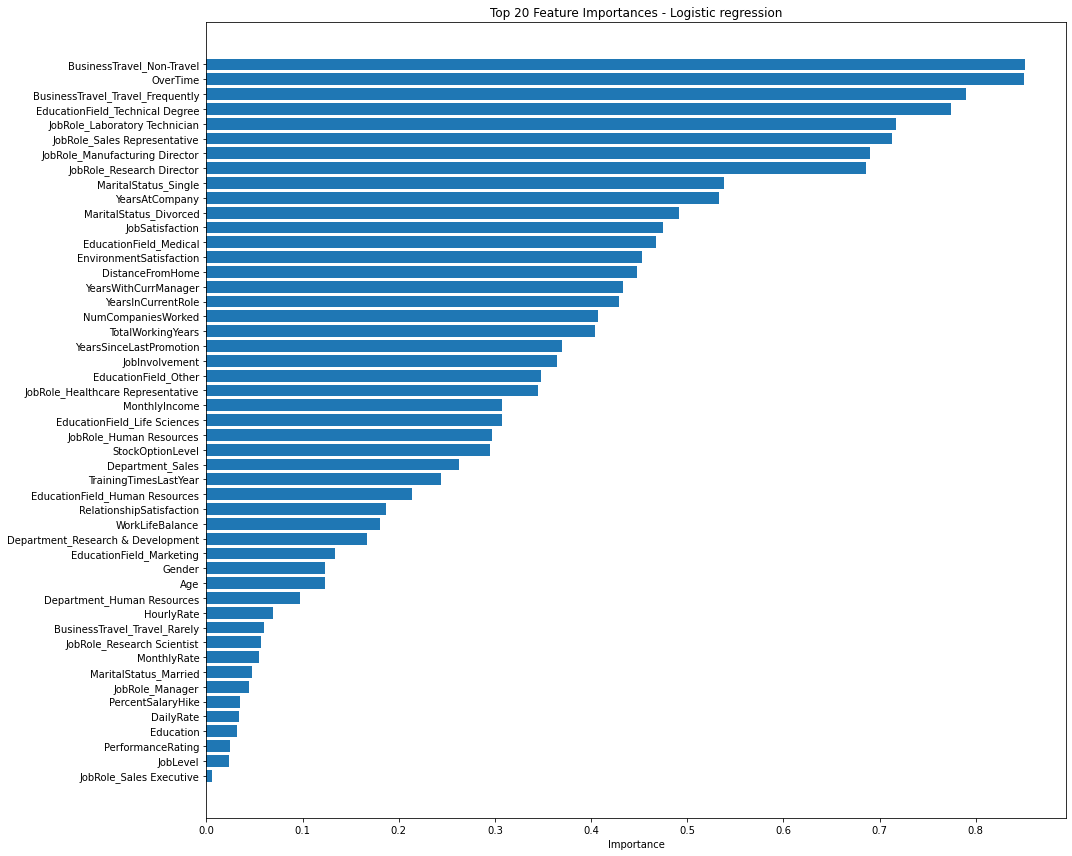

In [113]:
feature_names = []

# Extract feature names from each transformer in the ColumnTransformer
for name, transformer, columns in preprocessor.transformers_:
    if name != 'remainder':
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_names = transformer.get_feature_names_out(columns)
        else:
            transformed_names = columns
        feature_names.extend(transformed_names)

m1 = model_1.named_steps['model']
importances = abs(m1.coef_[0])

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Logistic regression')
plt.tight_layout()
plt.show()

In [114]:
# For further analysis, only the numerical features with the greatest positive feature importance will be be used: 'OverTime', 'YearsAtCompany', 'JobSatisfaction', 'EnvironmentSatisfaction', 'DistanceFromHome', 'YearsWithCurrManager', 'YearsInCurrentRole', 'NumCompaniesWorked', 'TotalWorkingYears', 'YearsSinceLastPromotion'
# All categorical features will be considered
num_shrink =['OverTime', 'YearsAtCompany', 'JobSatisfaction', 'EnvironmentSatisfaction', 'DistanceFromHome', 'YearsWithCurrManager', 'YearsInCurrentRole', 'NumCompaniesWorked', 'TotalWorkingYears', 'YearsSinceLastPromotion']
attr = list(num_shrink) + list(cat_attr)

In [115]:
preprocessor_shrink = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_shrink),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_attr_shrink)
])

In [116]:
X_train_top = X_train[attr]
X_test_top = X_test[attr]

In [117]:
undersample_pipeline = ImbPipeline(steps=[
    ("preprocessing", preprocessor_shrink),
    ("undersample", RandomUnderSampler(random_state=42)),
    ("model", LogisticRegression())
])

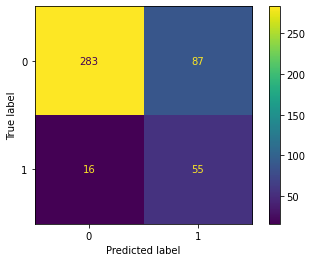

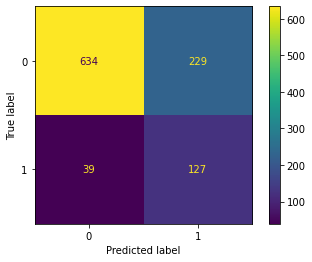

In [118]:
# Logistic regression model
undersample_pipeline.fit(X_train_top, y_train)

# Model performance evaluation for test and train set
y_pred = undersample_pipeline.predict(X_test_top)
y_pred_tr = undersample_pipeline.predict(X_train_top)
# Confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(undersample_pipeline, X_test_top, y_test)
# Confusion matrix for train set
ConfusionMatrixDisplay.from_estimator(undersample_pipeline, X_train_top, y_train)

In [119]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.76      0.85       370
           1       0.39      0.77      0.52        71

    accuracy                           0.77       441
   macro avg       0.67      0.77      0.68       441
weighted avg       0.86      0.77      0.79       441



In [120]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.94      0.73      0.83       863
           1       0.36      0.77      0.49       166

    accuracy                           0.74      1029
   macro avg       0.65      0.75      0.66      1029
weighted avg       0.85      0.74      0.77      1029



In [121]:
# Gather some metrics for future comparison of models performance
metrics_8 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

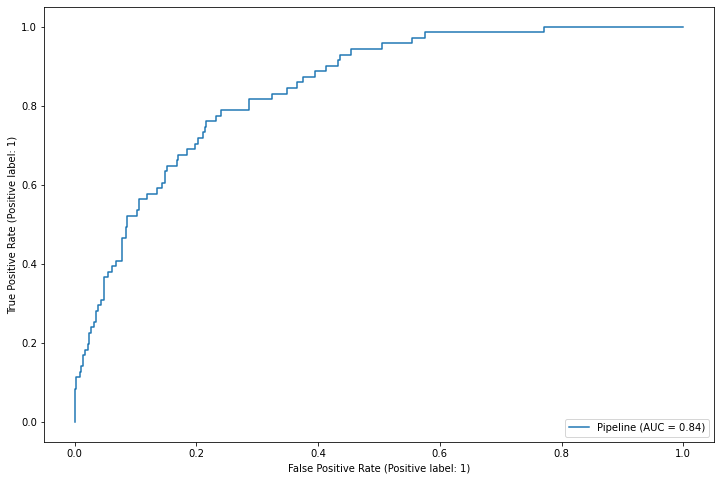

In [122]:
# ROC curve
plot_roc_curve(undersample_pipeline, X_test, y_test)

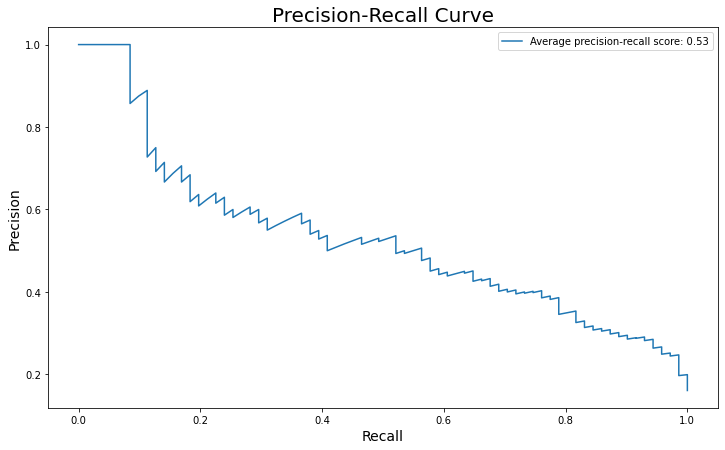

In [123]:
# Precision-Recall curve
plot_precision_recall_curve(undersample_pipeline, X_test, y_test)

In [124]:
# Row with model
row_8 = create_model_summary_row("Logistic regression with undersampling", metrics_8)

# **Logistic Regression with oversampling**

In [125]:
oversample_pipeline = ImbPipeline(steps=[
    ("preprocessing", preprocessor_shrink),
    ("oversample", RandomOverSampler(random_state=42)),
    ("model", LogisticRegression())
])

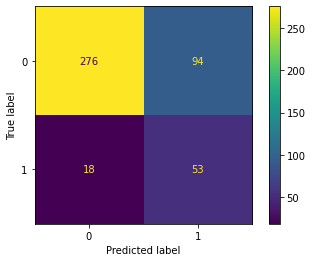

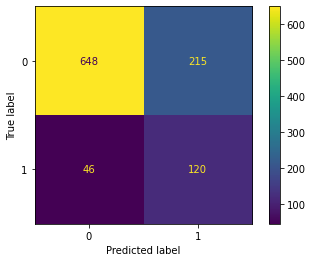

In [126]:
# Logistic regression model
oversample_pipeline.fit(X_train_top, y_train)

# Model performance evaluation for test and train set
y_pred = oversample_pipeline.predict(X_test_top)
y_pred_tr = oversample_pipeline.predict(X_train_top)
# Confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(oversample_pipeline, X_test_top, y_test)
# Confusion matrix for train set
ConfusionMatrixDisplay.from_estimator(oversample_pipeline, X_train_top, y_train)

In [127]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.75      0.83       370
           1       0.36      0.75      0.49        71

    accuracy                           0.75       441
   macro avg       0.65      0.75      0.66       441
weighted avg       0.85      0.75      0.78       441



In [128]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       863
           1       0.36      0.72      0.48       166

    accuracy                           0.75      1029
   macro avg       0.65      0.74      0.66      1029
weighted avg       0.84      0.75      0.78      1029



In [129]:
# Gather some metrics for future comparison of models performance
metrics_9 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

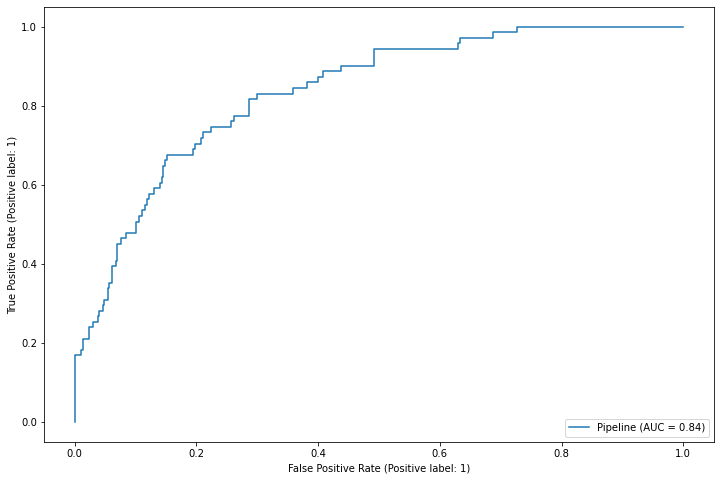

In [130]:
# ROC curve
plot_roc_curve(oversample_pipeline, X_test, y_test)

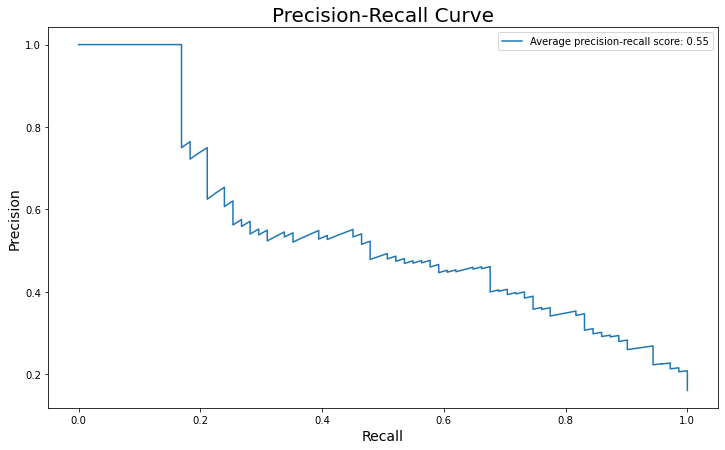

In [131]:
# Precision-Recall curve
plot_precision_recall_curve(oversample_pipeline, X_test, y_test)

In [132]:
# Row with model
row_9 = create_model_summary_row("Logistic regression with oversampling", metrics_9)

# **Logistic regression with SMOTE**

In [133]:
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0 numpy==1.23.5 pandas==1.5.3 --quiet --user

In [134]:
smote_pipeline = ImbPipeline(steps=[
    ("preprocessing", preprocessor_shrink),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression())
])

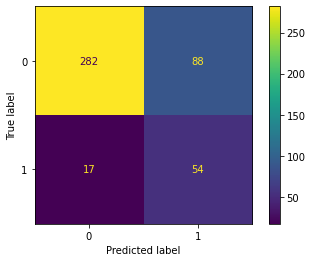

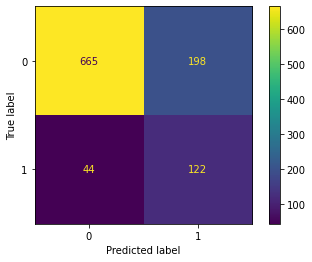

In [135]:
#Logistic regression model
smote_pipeline.fit(X_train_top, y_train)

# Model performance evaluation for test and train set
y_pred = smote_pipeline.predict(X_test_top)
y_pred_tr = smote_pipeline.predict(X_train_top)
# Confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(smote_pipeline, X_test_top, y_test)
# Confusion matrix for train set
ConfusionMatrixDisplay.from_estimator(smote_pipeline, X_train_top, y_train)

In [136]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       370
           1       0.38      0.76      0.51        71

    accuracy                           0.76       441
   macro avg       0.66      0.76      0.68       441
weighted avg       0.85      0.76      0.79       441



In [137]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.94      0.77      0.85       863
           1       0.38      0.73      0.50       166

    accuracy                           0.76      1029
   macro avg       0.66      0.75      0.67      1029
weighted avg       0.85      0.76      0.79      1029



In [138]:
# Gather some metrics for future comparison of models performance
metrics_10 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

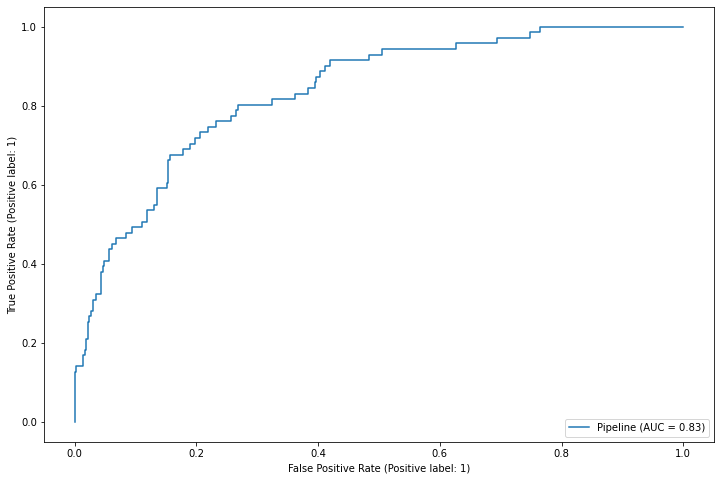

In [139]:
# ROC curve
plot_roc_curve(smote_pipeline, X_test, y_test)

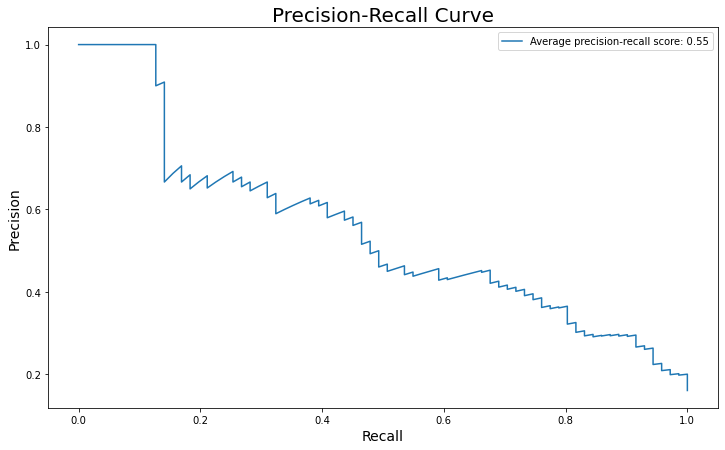

In [140]:
# Precision-Recall curve
plot_precision_recall_curve(smote_pipeline, X_test, y_test)

In [141]:
# Row with model
row_10 = create_model_summary_row("Logistic regression with SMOTE", metrics_10)

## **Best model summary**

In [142]:
new_rows = pd.DataFrame([row_8, row_9, row_10])
results = pd.concat([results, new_rows], ignore_index=True)
results

,model,tp,tn,fp,fn,correct,incorrect,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,roc_auc,avg_pre
0,Logistic Regression,35,358,12,36,393,48,0.893100,0.891156,0.811111,0.744681,0.439759,0.492958,0.570312,0.593220,0.730263,0.449
1,Random Forest,10,367,3,61,377,64,1.000000,0.854875,1.000000,0.769231,1.000000,0.140845,1.000000,0.238095,0.566368,0.247
2,Decision Tree,19,311,59,52,330,111,1.000000,0.748299,1.000000,0.243590,1.000000,0.267606,1.000000,0.255034,0.554073,0.183
3,Ada Boost,32,355,15,39,387,54,0.913508,0.877551,0.888889,0.680851,0.530120,0.450704,0.664151,0.542373,0.705082,0.395
4,Gradeint Boosting,18,358,12,53,376,65,0.960155,0.852608,0.992126,0.600000,0.759036,0.253521,0.860068,0.356436,0.610544,0.272
5,XGBoosting,21,357,13,50,378,63,1.000000,0.857143,1.000000,0.617647,1.000000,0.295775,1.000000,0.400000,0.630320,0.296
6,CatBoost,15,364,6,56,379,62,0.989310,0.859410,1.000000,0.714286,0.933735,0.211268,0.965732,0.326087,0.597526,0.278
7,Logistic regression with undersampling,55,283,87,16,338,103,0.739553,0.766440,0.356742,0.387324,0.765060,0.774648,0.486590,0.516432,0.769756,0.336
8,Logistic regression with oversampling,53,276,94,18,329,112,0.746356,0.746032,0.358209,0.360544,0.722892,0.746479,0.479042,0.486239,0.746212,0.310
9,Logistic regression with SMOTE,54,282,88,17,336,105,0.764820,0.761905,0.381250,0.380282,0.734940,0.760563,0.502058,0.507042,0.761363,0.328


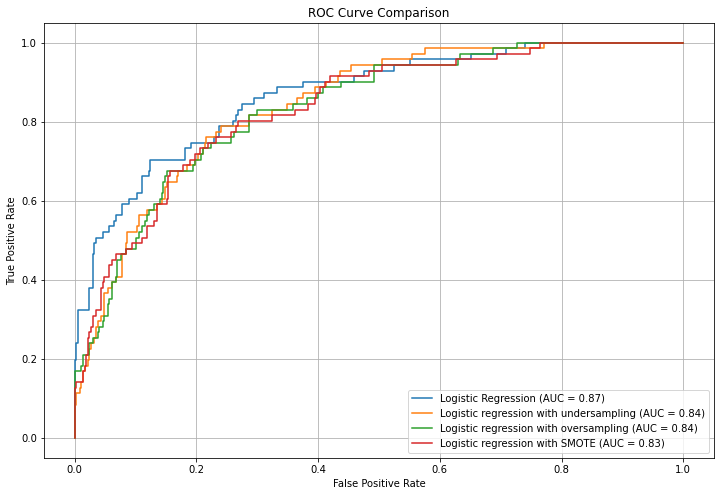

In [143]:
# Roc for all mogistic regression models
models = models = {
    "Logistic Regression": model_1,
    "Logistic regression with undersampling": undersample_pipeline,
    "Logistic regression with oversampling": oversample_pipeline,
    "Logistic regression with SMOTE": smote_pipeline
}
plt.figure(figsize=(12, 8))
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name, ax=plt.gca())
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Models summary**

* Baseline Logistic regression model has the highest test accuracy, highest precision and F1 score. It has good ROC AUC and average precision. The drawback is that the recall is lowest - misses more positive cases than others.
* Undersampling model has the highest recall but the lowest precision. It has moderate F! and highest ROC AUC. Seems to be the best option for maximizing recall.
* Oversampling model results are similar to indersampling model but it has slightly lower performance overall.
* SMOTE model is a balanced option between undersampling and oversampling. It has slightly better precision and F1 than oversampling. 

* **Undersampling model** is the best for attrition detection. It has the highest recall - correctly detects almost 78% of attrition cases. It has the best ROC AUC 77%. Althoug it has lower precision, in attrition detection false positives are less harmful than false negatives.

## **Making a predictive system**

In [144]:
input_data = (0, 9, 4, 3, 2, 3, 7, 4, 12, 7, 'Travel_Rarely', 'Sales', 'Medical', 'Sales Executive', 'Single')

# Changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# Reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

example = pd.DataFrame(input_data_reshaped)
example.columns = X_test_top.columns

best_model = undersample_pipeline

prediction = best_model.predict(example)

if (prediction[0] == 0):
  print('The person will stay.')
else:
  print('The person will leave.')

The person will stay.


In [145]:
example.T

,0
OverTime,0
YearsAtCompany,9
JobSatisfaction,4
EnvironmentSatisfaction,3
DistanceFromHome,2
YearsWithCurrManager,3
YearsInCurrentRole,7
NumCompaniesWorked,4
TotalWorkingYears,12
YearsSinceLastPromotion,7


## **Saving the trained model**

In [146]:
filename = './model/trained_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [147]:
# loading the saved model
loaded_model = pickle.load(open(filename, 'rb'))

In [148]:
input_data = (1, 9, 4, 3, 2, 3, 7, 4, 12, 7, 'Travel_Rarely', 'Sales', 'Medical', 'Sales Executive', 'Married')

# Changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

example = pd.DataFrame(input_data_reshaped)
example.columns = X_test_top.columns

prediction = loaded_model.predict(example)

if (prediction[0] == 0):
  print('The person will stay.')
else:
  print('The person will leave.')

The person will leave.


In [149]:
example.T

,0
OverTime,1
YearsAtCompany,9
JobSatisfaction,4
EnvironmentSatisfaction,3
DistanceFromHome,2
YearsWithCurrManager,3
YearsInCurrentRole,7
NumCompaniesWorked,4
TotalWorkingYears,12
YearsSinceLastPromotion,7


In [150]:
# Versions of all imports
print(f"Numpy:            {np.__version__}")
print(f"Pandas:           {pd.__version__}")
print(f"Matplotlib:       {matplotlib.__version__}")
print(f"Seaborn:          {sns.__version__}")
print(f"Scikit-learn:     {sklearn.__version__}")
print(f"Imbalanced-learn: {imblearn.__version__}")
print(f"XGBoost:          {xgboost.__version__}")
print(f"CatBoost:         {catboost.__version__}")
print(f"Joblib:           {joblib.__version__}")

Numpy:            1.23.5
Pandas:           1.3.4
Matplotlib:       3.4.3
Seaborn:          0.11.2
Scikit-learn:     1.3.2
Imbalanced-learn: 0.11.0
XGBoost:          2.1.4
CatBoost:         1.2.8
Joblib:           1.5.1
